**Tunning dos hiperparâmetros**
- Será realizado o tunning para os seguintes casos:
    1) sem informações do WHOQOL na base
    2) com todas as respostas do WHOQOL
    3) só com o índice final do WHOQOL
    4) só com os índices dos domínios do WHOQOL

- Para os seguintes modelos:
    1) Random Forest
    2) SVM
    3) MLP
    4) XGBoost

**Workflow:**
Para cada caso:
1. Importar dados
2. Separar em treino, teste e validação.
3. Definir os parâmetros a serem testados
4. Realizar o tunning
5. Salvar os resultados graficamente
6. Salvar o melhor modelo
7. Aplicar o Random Under-Sampling no treino (Voltar para o passo 3).


## SETUP
(Executar apenas uma vez)

In [1]:
# Instalando bibliotecas
!pip install -U pandas
!pip install -U numpy
!pip install -U scipy
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install -U xgboost
!pip install -U mlxtend
!pip install -U joblib
!pip install -U seaborn
!pip install -U matplotlib


## Inicialização
(Executar sempre que reiniciar o kernel)

### Importando as bibliotecas

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import KFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Importando modelo Dummy:
from sklearn.dummy import DummyClassifier
import pickle
import time
import multiprocessing
n_cpus = multiprocessing.cpu_count()

import warnings
warnings.filterwarnings('ignore')

np.random.seed(13) # Para reproduzir os resultados

### Definindo a função

In [2]:
def perform_model_tuning(models, param_grids, base_name, data=None, target=None, x_train = None, y_train=None, x_test=None,  y_test=None):
    
    if data is not None and target is not None:
        # Dividir os dados em treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    elif x_train is not None and x_test is not None and y_train is not None and y_test is not None:
        X_train = x_train
        X_test = x_test
        y_train = y_train
        y_test = y_test
    else:
        raise ValueError("Parâmetros inválidos. É necessário passar os dados e os rótulos ou os conjuntos de treino e teste.")

    start_tunning = time.time()
    
    best_models = {}  # Dicionário para armazenar o melhor modelo de cada tipo
    model_accuracies = {}  # Dicionário para armazenar as acurácias de cada modelo
    current_dir = os.getcwd()
    for model_name, model, param_grid_entry in zip(models.keys(), models.values(), param_grids):
        print(f"Tuning do modelo {model_name} iniciado...")

        # Acessar o dicionário de parâmetros correspondente ao modelo atual
        param_grid = param_grid_entry['params']

        # Realizar a busca em grid para encontrar os melhores parâmetros
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=n_cpus, verbose=True)
        
        # Iniciar a contagem do tempo
        start = time.time()
        
        grid_search.fit(X_train, y_train)
        
        # Finalizar a contagem do tempo
        end = time.time()
        print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name}")
        # Melhor modelo encontrado
        best_model = grid_search.best_estimator_

        # Fazer previsões no conjunto de teste
        y_pred = best_model.predict(X_test)

        # Calcular a acurácia do modelo
        accuracy = accuracy_score(y_test, y_pred)
        model_accuracies[model_name] = accuracy

        print(f"Acurácia do modelo {model_name}: {accuracy:.4f}")

        # Salvar o melhor modelo
        best_models[model_name] = best_model

    # Plotar gráfico de desempenho comparativo
    plt.figure(figsize=(10, 6))
    plt.bar(model_accuracies.keys(), model_accuracies.values())
    plt.xlabel('Modelos')
    plt.ylabel('Acurácia')
    plt.title('Comparação de desempenho dos modelos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    graph_filename = f"{base_name}_graph.png"
    graph_path = os.path.join(current_dir, graph_filename)
    plt.savefig(graph_path)
    plt.close()

    end_tunning = time.time()

    #Pickle the single best model, verifying the best and saving from best_models dict, se tiver mais algo salvo com o mesmo nome, adiciona mais um.
    best_model = max(model_accuracies, key=model_accuracies.get)
    print(f"\n\nMelhor modelo: {best_model} | Acurácia: {model_accuracies[best_model]}")
    print(f"\nTempo de execução total :{end_tunning - start_tunning:.2f}s")
    best_model = best_models[best_model]
    
    if os.path.exists(f"{base_name}_best_model.pkl"):
        i = 1
        while os.path.exists(f"{base_name}_best_model_{i}.pkl"):
            i += 1
        pickle.dump(best_model, open(f"{base_name}_best_model_{i}.pkl", "wb"))
    else:
        pickle.dump(best_model, open(f"{base_name}_best_model.pkl", "wb"))
    
    # Salvar tabela com os valores de acurácia
    table_filename = f"{base_name}_acuracy.csv"
    accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Acurácia'])
    table_path = os.path.join(current_dir, table_filename)
    accuracies_df.to_csv(table_path, index=False)

    return best_models

In [3]:
def ler_arquivo_txt(nome_arquivo):
    with open(nome_arquivo, 'r') as arquivo:
        vetor_strings = []
        for linha in arquivo:
            valores = linha.strip().replace('(', '').replace(')', '').replace("'", '').split(', ')
            vetor_strings.append(valores)
    return vetor_strings

In [4]:
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_input, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_input, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)


# Função que chama os 4 modelos e retorna o resultado de cada um usando a função avalia_modelo_cv e imprime o resultado de cada um.

def avalia_dif_modelos_cv(X_train, y_test, cv):
    # Criando os modelos
    dummy_av = DummyClassifier(strategy='most_frequent', random_state=13)
    rf_av = RandomForestClassifier(n_jobs=n_cpus, random_state=13)
    svm_av = SVC(kernel='rbf', gamma='auto', decision_function_shape='ovo', random_state=13)
    mlp_av = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=13)
    xgb_av = XGBClassifier(n_jobs=n_cpus, random_state=13)
    knn_av = KNeighborsClassifier(n_jobs=n_cpus)
    ada_av = AdaBoostClassifier(random_state=13)
    nvb_av = GaussianNB()
    lr_av = LogisticRegression(random_state=13)
    dt_av = DecisionTreeClassifier(random_state=13)
    ext_av = ExtraTreesClassifier(random_state=13, n_jobs=n_cpus)
    

    # Aplicando a função de avaliação
    dummy_fun_av = avalia_modelo_cv(dummy_av, X_train, y_test, cv)
    rf_fun_av = avalia_modelo_cv(rf_av, X_train, y_test, cv)
    svm_fun_av = avalia_modelo_cv(svm_av, X_train, y_test, cv)
    mlp_fun_av = avalia_modelo_cv(mlp_av, X_train, y_test, cv)
    xgb_fun_av = avalia_modelo_cv(xgb_av, X_train, y_test, cv)
    knn_fun_av = avalia_modelo_cv(knn_av, X_train, y_test, cv)
    ada_fun_av = avalia_modelo_cv(ada_av, X_train, y_test, cv)
    nvb_fun_av = avalia_modelo_cv(nvb_av, X_train, y_test, cv)
    lr_fun_av = avalia_modelo_cv(lr_av, X_train, y_test, cv)
    dt_fun_av = avalia_modelo_cv(dt_av, X_train, y_test, cv)
    ext_fun_av = avalia_modelo_cv(ext_av, X_train, y_test, cv)
    

    # Criando o dataframe com os resultados
    df_resultado = pd.DataFrame({'Modelo': ['Dummy', 'RF', 'SVM', 'MLP', 'XGB', 'KNN', 'ADA', 'NVB', 'LR', 'DT', 'EXT'],
                                 'Acurácia': [dummy_fun_av, rf_fun_av, svm_fun_av, mlp_fun_av, xgb_fun_av, knn_fun_av, ada_fun_av, nvb_fun_av, lr_fun_av, dt_fun_av, ext_fun_av]})


    # Ordenando o dataframe pela acurácia
    df_resultado = df_resultado.sort_values(by='Acurácia', ascending=False)

    # Define a color dictionary for each model
    model_colors = {
        'Dummy': 'gray',
        'RF': 'blue',
        'SVM': 'green',
        'MLP': 'orange',
        'XGB': 'purple',
        'KNN': 'brown',
        'ADA': 'pink',
        'NVB': 'red',
        'LR': 'cyan',
        'DT': 'olive',
        'EXT': 'black'
    }

    # Plotando o gráfico de barras, que vai de 0 a 1
    ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])
    plt.xlim(0, 1)

    # Adicionando os valores nas barras
    for index, value in enumerate(df_resultado['Acurácia']):
        ax.text(value + 0.01, index, f'{value:.4f}', va='center', fontsize=8, color='black')

    plt.show("Desempenho dos modelos")
    #%matplotlib inline

    return df_resultado

In [5]:
def perform_cross_validation(model, X, y, cv, verbose=True):
    reports = []
    predictions = cross_val_predict(model, X, y, cv=cv)

    for fold in range(cv):
        start = fold * len(X) // cv
        end = (fold + 1) * len(X) // cv
        report = classification_report(y[start:end], predictions[start:end], output_dict=True)
        reports.append(report)

        if verbose:
            print(f"Fold {fold + 1} Classification Report:")
            print(classification_report(y[start:end], predictions[start:end]))
            print("-" * 50)

    avg_report = {
        'precision': np.mean([report['weighted avg']['precision'] for report in reports]),
        'recall': np.mean([report['weighted avg']['recall'] for report in reports]),
        'f1-score': np.mean([report['weighted avg']['f1-score'] for report in reports]),
        'support': np.mean([report['weighted avg']['support'] for report in reports])
    }

    accuracy = accuracy_score(y, predictions)

    if verbose or not verbose:
        print("Average Classification Report:")
        print(classification_report(y, predictions))
        print("-" * 50)
        print(f"Accuracy: {accuracy:.2f}")

    return None


In [6]:
# Função para aplicar SBFS e SFFS com cross validation e salvar tabela com resultado.
def perform_feature_selection(data, target, model, best_model, method, cv):
    # Criando o objeto de seleção de features
    if method == 'SBFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=False,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=n_cpus)
    elif method == 'SFFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=True,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=n_cpus)
    # Aplicando o método de seleção de features
    sfs = sfs.fit(data, target)
    # Salvando o resultado em um dataframe
    df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Definindo nome do arquivo para salvar as features selecionadas em formato CSV
    if os.path.exists(f"results/{method}_{best_model}.csv"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.csv"):
            i += 1
        file_name_csv = f"results/{method}_{best_model}_{i}.csv"
    else:
        file_name_csv = f"results/{method}_{best_model}.csv"

    # Salvando o dataframe em um arquivo CSV
    df.to_csv(file_name_csv, index=False)

    # Definindo nome do arquivo para salvar as features selecionadas em formato TXT
    if os.path.exists(f"results/{method}_{best_model}.txt"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.txt"):
            i += 1
        file_name_txt = f"results/{method}_{best_model}_{i}.txt"
    else:
        file_name_txt = f"results/{method}_{best_model}.txt"

    # Salvando as features selecionadas e o score em um arquivo TXT
    with open(file_name_txt, 'w') as file:
        file.write(f"Selected Features: {', '.join(sfs.k_feature_names_)}\n")
        file.write(f"Score: {sfs.k_score_}")

    # Plotando o desempenho do modelo para cada combinação de atributos
    fig, ax = plt.subplots()
    ax.plot(range(1, len(df) + 1), df['avg_score'], marker='o')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Average Score')
    ax.set_title('Performance of Model with Feature Selection')
    plt.xticks(range(1, len(df) + 1))
    plt.grid(True)

    # Definindo nome do arquivo para salvar o gráfico
    if os.path.exists(f"results/{method}_{best_model}.png"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.png"):
            i += 1
        file_name_plot = f"results/{method}_{best_model}_{i}.png"
    else:
        file_name_plot = f"results/{method}_{best_model}.png"

    # Salvando o gráfico em um arquivo PNG
    plt.savefig(file_name_plot)

    # Retornando as features selecionadas e o score
    return sfs.k_feature_names_, sfs.k_score_

In [7]:
def updt_maxfeature(modelo):
    try:
        if modelo.get_params()['max_features'] == 'auto':
            modelo.max_features = 'sqrt'
            print(modelo)
    except:
        pass


### Importando os dados

In [8]:
# Sem WHOQOL:
base1 = pd.read_csv('Datasets/dataframe_socioeconomico_Niveis.csv')
data1 = base1.drop('Nivel_MHI', axis=1)
target1 = base1['Nivel_MHI']
le = LabelEncoder()
target1 = le.fit_transform(target1)

# Dividir os dados em treino e teste
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, target1, test_size=0.2, random_state=13, stratify=target1)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train1_re, y_train1_re = sampler.fit_resample(X_train1, y_train1)

# Divide em train_re e val_re
X_train1_re, X_val1_re, y_train1_re, y_val1_re = train_test_split(X_train1_re, y_train1_re, test_size=0.2, random_state=13, stratify=y_train1_re)


In [9]:
# Com todas as respostas do WHOQOL
base2 = pd.read_csv('Datasets/df_social_whoqol_tratado_1.csv')
data2 = base2.drop('Nivel_MHI', axis=1)
target2 = base2['Nivel_MHI']
target2 = le.fit_transform(target2)

# Dividir os dados em treino e teste
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2, random_state=13, stratify=target2)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train2_re, y_train2_re = sampler.fit_resample(X_train2, y_train2)

# Divide em train_re e val_re
X_train2_re, X_val2_re, y_train2_re, y_val2_re = train_test_split(X_train2_re, y_train2_re, test_size=0.2, random_state=13, stratify=y_train2_re)


In [10]:
# Só com o indice dos dominiosdo WHOQOL, concatenar base1 com final da base2
data3 = pd.concat([data1, base2.loc[:,['CR','CS','CT','CU']]], axis=1)
target3 = base2['Nivel_MHI']
target3 = le.fit_transform(target3)

# Dividir os dados em treino e teste
X_train3, X_test3, y_train3, y_test3 = train_test_split(data3, target3, test_size=0.2, random_state=13, stratify=target3)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train3_re, y_train3_re = sampler.fit_resample(X_train3, y_train3)

# Divide em train_re e val_re
X_train3_re, X_val3_re, y_train3_re, y_val3_re = train_test_split(X_train3_re, y_train3_re, test_size=0.2, random_state=13, stratify=y_train3_re)

In [11]:
# Só com a qualidade de vida do WHOQOL
data4 = pd.concat([data1, base2['BR']], axis=1)
target4 = base2['Nivel_MHI']
target4 = le.fit_transform(target4)

# Dividir os dados em treino e teste
X_train4, X_test4, y_train4, y_test4 = train_test_split(data4, target4, test_size=0.2, random_state=13, stratify=target4)

sampler = RandomUnderSampler(random_state=13)
X_train4_re, y_train4_re = sampler.fit_resample(X_train4, y_train4)

# Divide em train_re e val_re
X_train4_re, X_val4_re, y_train4_re, y_val4_re = train_test_split(X_train4_re, y_train4_re, test_size=0.2, random_state=13, stratify=y_train4_re)

In [12]:
# Qualidade de Vida Geral ( Media das duas primeiras questões do WHOQOL)
# Pegar a média das duas primeiras colunas da base2, pelo indice
data5 = pd.concat([data1, base2.loc[:,['BR','BS']].mean(axis=1)], axis=1)
target5 = base2['Nivel_MHI']
target5 = le.fit_transform(target5)

# Dividir os dados em treino e teste
X_train5, X_test5, y_train5, y_test5 = train_test_split(data5, target5, test_size=0.2, random_state=13, stratify=target5)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
# Como string 

X_train5.columns = X_train5.columns.astype(str)

X_train5_re, y_train5_re = sampler.fit_resample(X_train5, y_train5)

# Divide em train_re e val_re
X_train5_re, X_val5_re, y_train5_re, y_val5_re = train_test_split(X_train5_re, y_train5_re, test_size=0.2, random_state=13, stratify=y_train5_re)

In [13]:
# Media de todos os dominios do WHOQOL
data6 = pd.concat([data1, base2.loc[:,['CR','CS','CT','CU']].mean(axis=1)], axis=1)
target6 = base2['Nivel_MHI']
target6 = le.fit_transform(target6)

# Dividir os dados em treino e teste
X_train6, X_test6, y_train6, y_test6 = train_test_split(data6, target6, test_size=0.2, random_state=13, stratify=target6)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)

# Como string
X_train6.columns = X_train6.columns.astype(str)

X_train6_re, y_train6_re = sampler.fit_resample(X_train6, y_train6)

# Divide em train_re e val_re
X_train6_re, X_val6_re, y_train6_re, y_val6_re = train_test_split(X_train6_re, y_train6_re, test_size=0.2, random_state=13, stratify=y_train6_re)

## Analise exploratória dos dados
- Ver numero de linhas e colunas de cada base, com e sem Random Under-Sampling. 
- Ver como ficou divisão de treino e teste.
- Ver como ficou a divisão de treino e validação.
- Ver como ficou a divisão de treino e teste com o Random Under-Sampling.

### Verificando o tamanho das bases

In [14]:
# Verificando o tamanho das bases 
print("Tamanho das bases:")
print(f"Base 1: {data1.shape}")
print(f"Base 2: {data2.shape}")
print(f"Base 3: {data3.shape}")
print(f"Base 4: {data4.shape}")
print(f"Base 5: {data5.shape}")
print(f"Base 6: {data6.shape}")


Tamanho das bases:
Base 1: (872, 54)
Base 2: (872, 84)
Base 3: (872, 58)
Base 4: (872, 55)
Base 5: (872, 55)
Base 6: (872, 55)


In [15]:
# Verificando o tamanho das bases de treino e teste
print("Tamanho das bases de treino e teste:")
print(f"Base 1: {X_train1.shape}, {X_test1.shape}")
print(f"Base 2: {X_train2.shape}, {X_test2.shape}")
print(f"Base 3: {X_train3.shape}, {X_test3.shape}")
print(f"Base 4: {X_train4.shape}, {X_test4.shape}")
print(f"Base 5: {X_train5.shape}, {X_test5.shape}")
print(f"Base 6: {X_train6.shape}, {X_test6.shape}")

Tamanho das bases de treino e teste:
Base 1: (697, 54), (175, 54)
Base 2: (697, 84), (175, 84)
Base 3: (697, 58), (175, 58)
Base 4: (697, 55), (175, 55)
Base 5: (697, 55), (175, 55)
Base 6: (697, 55), (175, 55)


In [16]:
# Verificando o tamanho das bases com Random Under-Sampling
print("Tamanho das bases com Random Under-Sampling:")
print(f"Base 1: Treino {X_train1_re.shape} {y_train1_re.shape} | Teste: {X_test1.shape} {y_test1.shape}")
print(f"Base 2: Treino {X_train2_re.shape} {y_train2_re.shape} | Teste: {X_test2.shape} {y_test2.shape}")
print(f"Base 3: Treino {X_train3_re.shape} {y_train3_re.shape} | Teste: {X_test3.shape} {y_test3.shape}")
print(f"Base 4: Treino {X_train4_re.shape} {y_train4_re.shape} | Teste: {X_test4.shape} {y_test4.shape}")
print(f"Base 5: Treino {X_train5_re.shape} {y_train5_re.shape} | Teste: {X_test5.shape} {y_test5.shape}")
print(f"Base 6: Treino {X_train6_re.shape} {y_train6_re.shape} | Teste: {X_test6.shape} {y_test6.shape}")

Tamanho das bases com Random Under-Sampling:
Base 1: Treino (285, 54) (285,) | Teste: (175, 54) (175,)
Base 2: Treino (285, 84) (285,) | Teste: (175, 84) (175,)
Base 3: Treino (285, 58) (285,) | Teste: (175, 58) (175,)
Base 4: Treino (285, 55) (285,) | Teste: (175, 55) (175,)
Base 5: Treino (285, 55) (285,) | Teste: (175, 55) (175,)
Base 6: Treino (285, 55) (285,) | Teste: (175, 55) (175,)


### Verificando a distribuição das classes

In [17]:
# Verificando a distribuição das classes
print("Distribuição das classes:")
print(f"Base 1: {np.unique(target1, return_counts=True)}")
print(f"Base 2: {np.unique(target2, return_counts=True)}")
print(f"Base 3: {np.unique(target3, return_counts=True)}")
print(f"Base 4: {np.unique(target4, return_counts=True)}")
print(f"Base 5: {np.unique(target5, return_counts=True)}")
print(f"Base 6: {np.unique(target6, return_counts=True)}")

Distribuição das classes:
Base 1: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 2: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 3: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 4: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 5: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 6: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))


In [18]:
# Verificando a distribuição das classes com Random Under-Sampling
print("Distribuição das classes com Random Under-Sampling:")
print(f"Base 1: {np.unique(y_train1_re, return_counts=True)}")
print(f"Base 2: {np.unique(y_train2_re, return_counts=True)}")
print(f"Base 3: {np.unique(y_train3_re, return_counts=True)}")
print(f"Base 4: {np.unique(y_train4_re, return_counts=True)}")
print(f"Base 5: {np.unique(y_train5_re, return_counts=True)}")
print(f"Base 6: {np.unique(y_train6_re, return_counts=True)}")

Distribuição das classes com Random Under-Sampling:
Base 1: (array([0, 1, 2]), array([95, 95, 95], dtype=int64))
Base 2: (array([0, 1, 2]), array([95, 95, 95], dtype=int64))
Base 3: (array([0, 1, 2]), array([95, 95, 95], dtype=int64))
Base 4: (array([0, 1, 2]), array([95, 95, 95], dtype=int64))
Base 5: (array([0, 1, 2]), array([95, 95, 95], dtype=int64))
Base 6: (array([0, 1, 2]), array([95, 95, 95], dtype=int64))


In [21]:
X_train1.describe()

,B,C,F,H,L,M,N,O,U,AC,...,J_5.0,AA_1.0,AA_2.0,AA_3.0,AA_4.0,AB_0.0,AB_1.0,AB_2.0,AB_3.0,AB_4.0
count,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,...,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000
mean,0.560976,22.327116,0.341463,0.883788,5.133429,4.832138,0.292683,0.728838,0.274032,0.325681,...,0.216643,0.233859,0.053085,0.380201,0.332855,0.001435,0.249641,0.539455,0.172166,0.037303
std,0.496624,4.411554,0.474541,1.022440,2.630663,1.984625,0.455321,0.444879,0.446345,0.468965,...,0.412253,0.423588,0.224363,0.485785,0.471574,0.037878,0.433116,0.498799,0.377796,0.189639
min,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,0.000000,0.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,21.000000,0.000000,1.000000,5.000000,5.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,23.000000,1.000000,1.000000,7.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,52.000000,1.000000,6.000000,10.000000,12.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Avaliando modelos sem Under-Sampling

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.04      0.08       119
           1       0.50      0.08      0.14       119
           2       0.67      0.98      0.79       459

    accuracy                           0.66       697
   macro avg       0.60      0.37      0.34       697
weighted avg       0.63      0.66      0.56       697

--------------------

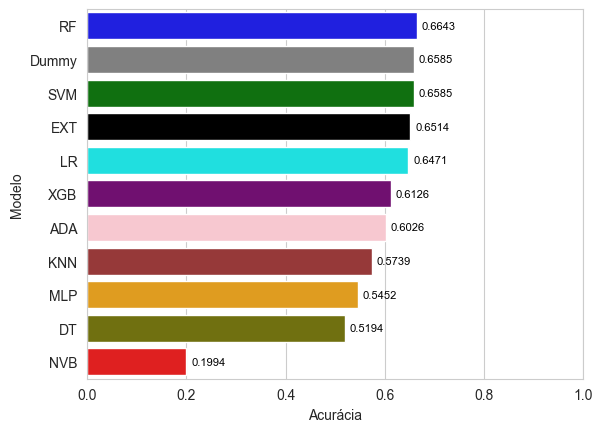

,Modelo,Acurácia
1,RF,0.664275
0,Dummy,0.658537
2,SVM,0.658537
10,EXT,0.651363
8,LR,0.647059
4,XGB,0.612626
6,ADA,0.602582
5,KNN,0.573888
3,MLP,0.545194
9,DT,0.519369


In [19]:
avalia_dif_modelos_cv(X_train1, y_train1, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.49      0.59       119
           1       0.78      0.54      0.64       119
           2       0.78      0.92      0.85       459

    accuracy                           0.78       697
   macro avg       0.77      0.65      0.69       697
weighted avg       0.78      0.78      0.77       697

--------------------

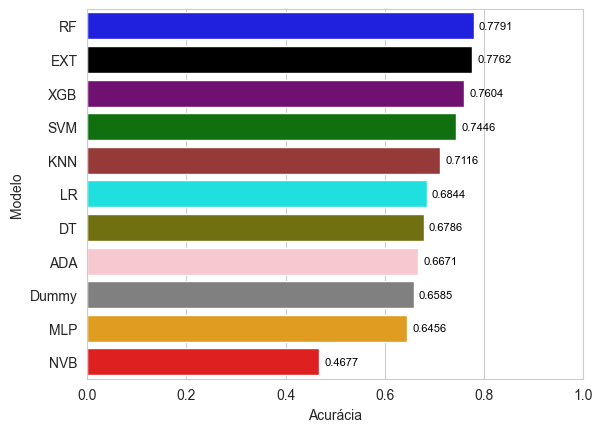

,Modelo,Acurácia
1,RF,0.779053
10,EXT,0.776184
4,XGB,0.760402
2,SVM,0.744620
5,KNN,0.711621
8,LR,0.684362
9,DT,0.678623
6,ADA,0.667145
0,Dummy,0.658537
3,MLP,0.645624


In [20]:
avalia_dif_modelos_cv(X_train2, y_train2, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.39      0.51       119
           1       0.78      0.50      0.61       119
           2       0.76      0.93      0.84       459

    accuracy                           0.76       697
   macro avg       0.76      0.61      0.65       697
weighted avg       0.76      0.76      0.74       697

--------------------

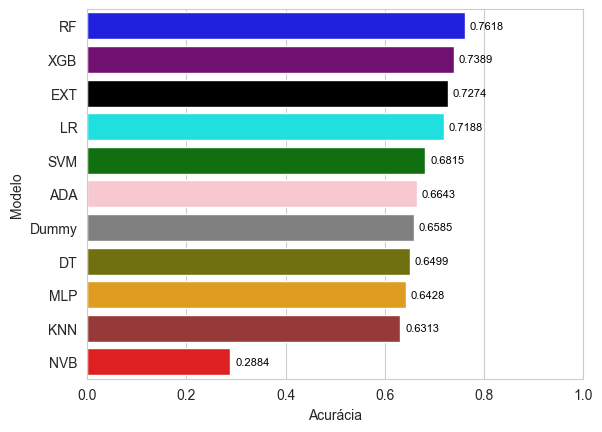

,Modelo,Acurácia
1,RF,0.761836
4,XGB,0.738881
10,EXT,0.727403
8,LR,0.718795
2,SVM,0.681492
6,ADA,0.664275
0,Dummy,0.658537
9,DT,0.649928
3,MLP,0.642755
5,KNN,0.631277


In [21]:
avalia_dif_modelos_cv(X_train3, y_train3, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.04      0.08       119
           1       0.68      0.18      0.28       119
           2       0.68      0.97      0.80       459

    accuracy                           0.67       697
   macro avg       0.62      0.40      0.38       697
weighted avg       0.65      0.67      0.59       697

--------------------

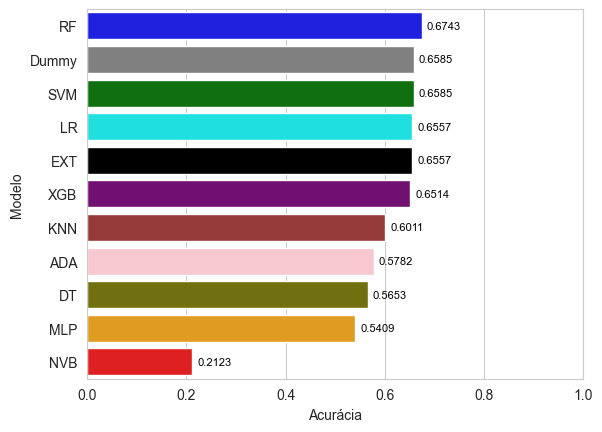

,Modelo,Acurácia
1,RF,0.674319
0,Dummy,0.658537
2,SVM,0.658537
8,LR,0.655667
10,EXT,0.655667
4,XGB,0.651363
5,KNN,0.601148
6,ADA,0.578192
9,DT,0.565280
3,MLP,0.540890


In [22]:
avalia_dif_modelos_cv(X_train4, y_train4, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.05      0.09       119
           1       0.70      0.22      0.33       119
           2       0.68      0.97      0.80       459

    accuracy                           0.68       697
   macro avg       0.64      0.41      0.41       697
weighted avg       0.66      0.68      0.60       697

--------------------

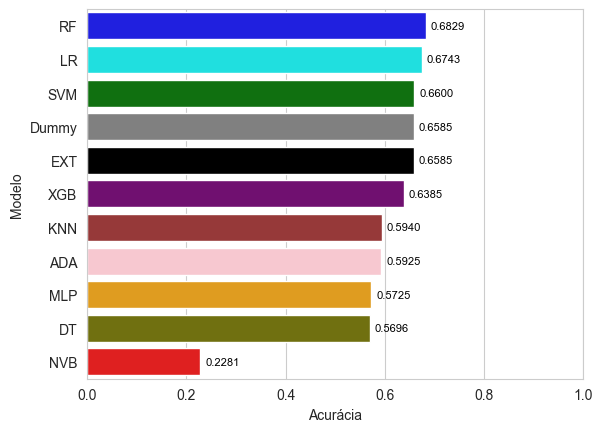

,Modelo,Acurácia
1,RF,0.682927
8,LR,0.674319
2,SVM,0.659971
0,Dummy,0.658537
10,EXT,0.658537
4,XGB,0.638451
5,KNN,0.593974
6,ADA,0.592539
3,MLP,0.572453
9,DT,0.569584


In [23]:
avalia_dif_modelos_cv(X_train5, y_train5, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.19      0.30       119
           1       0.71      0.27      0.39       119
           2       0.70      0.95      0.81       459

    accuracy                           0.71       697
   macro avg       0.71      0.47      0.50       697
weighted avg       0.71      0.71      0.65       697

--------------------

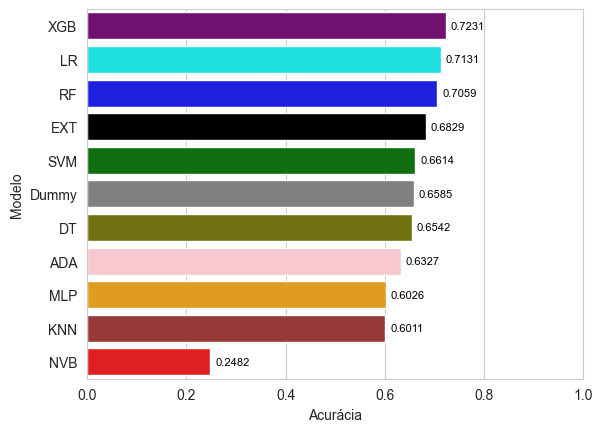

,Modelo,Acurácia
4,XGB,0.723099
8,LR,0.713056
1,RF,0.705882
10,EXT,0.682927
2,SVM,0.661406
0,Dummy,0.658537
9,DT,0.654232
6,ADA,0.632712
3,MLP,0.602582
5,KNN,0.601148


In [24]:
avalia_dif_modelos_cv(X_train6, y_train6, 5)

## Avaliando modelos com Under-Sampling

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.33      0.30        95
           1       0.28      0.34      0.31        95
           2       0.25      0.15      0.18        95

    accuracy                           0.27       285
   macro avg       0.27      0.27      0.26       285
weighted avg       0.27      0.27      0.26       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.37      0.36        95
           1       0.56      0.61      0.59        95
           2       0.37      0.32      0.34        95

    accuracy                           0.43       285
   macro avg       0.43      0.43      0.43       285
weighted avg       0.43      0.43      0.43       285

--------------------

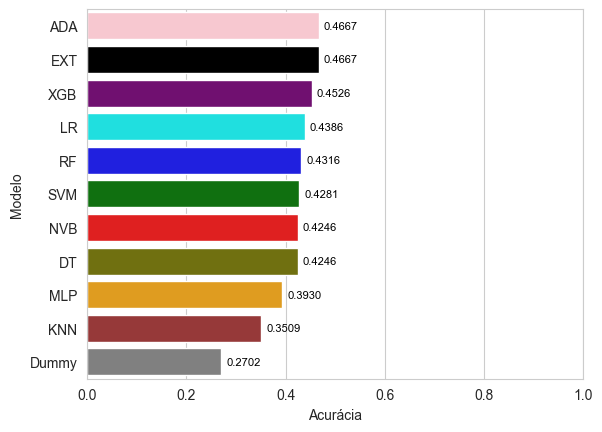

,Modelo,Acurácia
6,ADA,0.466667
10,EXT,0.466667
4,XGB,0.452632
8,LR,0.438596
1,RF,0.431579
2,SVM,0.428070
7,NVB,0.424561
9,DT,0.424561
3,MLP,0.392982
5,KNN,0.350877


In [25]:
# Avaliando os modelos para cada dado com o treino
avalia_dif_modelos_cv(X_train1_re, y_train1_re, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.33      0.30        95
           1       0.28      0.34      0.31        95
           2       0.25      0.15      0.18        95

    accuracy                           0.27       285
   macro avg       0.27      0.27      0.26       285
weighted avg       0.27      0.27      0.26       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79        95
           1       0.85      0.88      0.87        95
           2       0.66      0.62      0.64        95

    accuracy                           0.77       285
   macro avg       0.76      0.77      0.77       285
weighted avg       0.76      0.77      0.77       285

--------------------

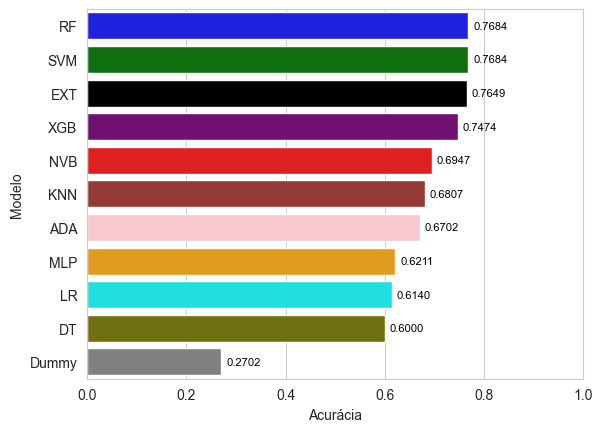

,Modelo,Acurácia
1,RF,0.768421
2,SVM,0.768421
10,EXT,0.764912
4,XGB,0.747368
7,NVB,0.694737
5,KNN,0.680702
6,ADA,0.670175
3,MLP,0.621053
8,LR,0.614035
9,DT,0.600000


In [26]:
avalia_dif_modelos_cv(X_train2_re, y_train2_re, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.33      0.30        95
           1       0.28      0.34      0.31        95
           2       0.25      0.15      0.18        95

    accuracy                           0.27       285
   macro avg       0.27      0.27      0.26       285
weighted avg       0.27      0.27      0.26       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        95
           1       0.84      0.88      0.86        95
           2       0.61      0.58      0.59        95

    accuracy                           0.74       285
   macro avg       0.73      0.74      0.73       285
weighted avg       0.73      0.74      0.73       285

--------------------

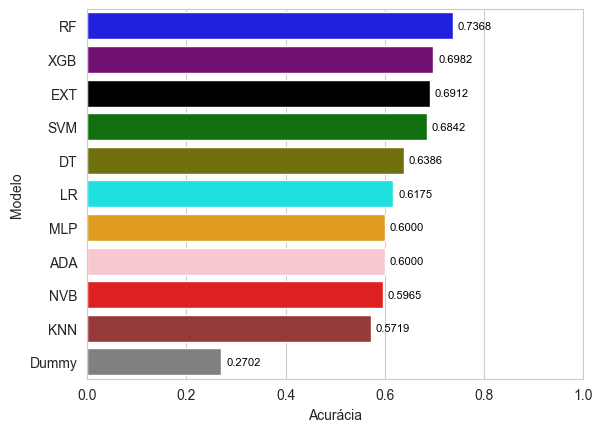

,Modelo,Acurácia
1,RF,0.736842
4,XGB,0.698246
10,EXT,0.691228
2,SVM,0.684211
9,DT,0.638596
8,LR,0.617544
3,MLP,0.600000
6,ADA,0.600000
7,NVB,0.596491
5,KNN,0.571930


In [27]:
avalia_dif_modelos_cv(X_train3_re, y_train3_re, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.33      0.30        95
           1       0.28      0.34      0.31        95
           2       0.25      0.15      0.18        95

    accuracy                           0.27       285
   macro avg       0.27      0.27      0.26       285
weighted avg       0.27      0.27      0.26       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.64      0.60        95
           1       0.65      0.78      0.71        95
           2       0.41      0.26      0.32        95

    accuracy                           0.56       285
   macro avg       0.54      0.56      0.54       285
weighted avg       0.54      0.56      0.54       285

--------------------

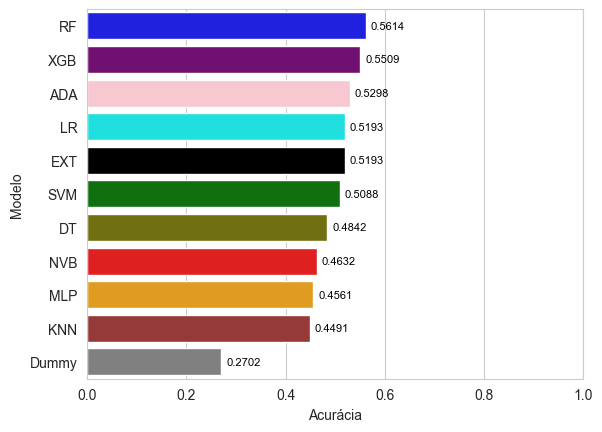

,Modelo,Acurácia
1,RF,0.561404
4,XGB,0.550877
6,ADA,0.529825
8,LR,0.519298
10,EXT,0.519298
2,SVM,0.508772
9,DT,0.484211
7,NVB,0.463158
3,MLP,0.456140
5,KNN,0.449123


In [28]:
avalia_dif_modelos_cv(X_train4_re, y_train4_re, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.33      0.30        95
           1       0.28      0.34      0.31        95
           2       0.25      0.15      0.18        95

    accuracy                           0.27       285
   macro avg       0.27      0.27      0.26       285
weighted avg       0.27      0.27      0.26       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.63      0.61        95
           1       0.65      0.77      0.70        95
           2       0.39      0.28      0.33        95

    accuracy                           0.56       285
   macro avg       0.54      0.56      0.55       285
weighted avg       0.54      0.56      0.55       285

--------------------

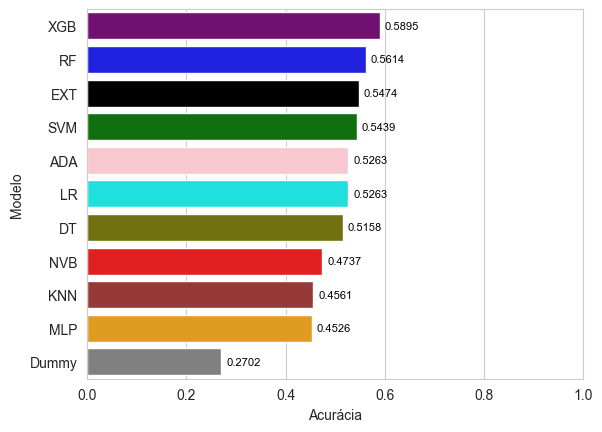

,Modelo,Acurácia
4,XGB,0.589474
1,RF,0.561404
10,EXT,0.547368
2,SVM,0.543860
6,ADA,0.526316
8,LR,0.526316
9,DT,0.515789
7,NVB,0.473684
5,KNN,0.456140
3,MLP,0.452632


In [29]:
avalia_dif_modelos_cv(X_train5_re, y_train5_re, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.33      0.30        95
           1       0.28      0.34      0.31        95
           2       0.25      0.15      0.18        95

    accuracy                           0.27       285
   macro avg       0.27      0.27      0.26       285
weighted avg       0.27      0.27      0.26       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        95
           1       0.77      0.87      0.82        95
           2       0.62      0.47      0.54        95

    accuracy                           0.71       285
   macro avg       0.70      0.71      0.70       285
weighted avg       0.70      0.71      0.70       285

--------------------

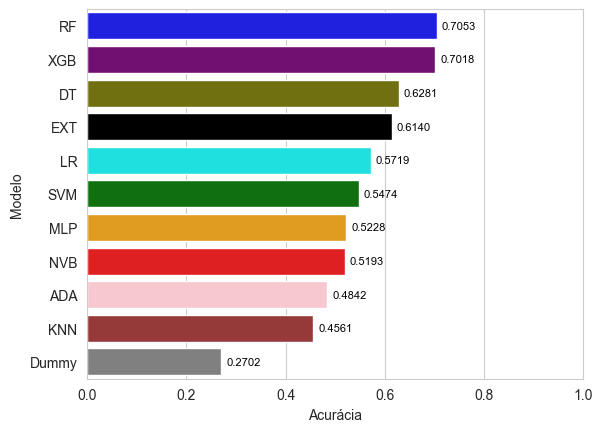

,Modelo,Acurácia
1,RF,0.705263
4,XGB,0.701754
9,DT,0.628070
10,EXT,0.614035
8,LR,0.571930
2,SVM,0.547368
3,MLP,0.522807
7,NVB,0.519298
6,ADA,0.484211
5,KNN,0.456140


In [30]:
avalia_dif_modelos_cv(X_train6_re, y_train6_re, 5)

 ## Avaliando modelos com Under-Sampling e Cross Validation

## Tunning dos hiperparâmetros

### Parametros para grid search

In [31]:
#Definindo parametros:
#Definir os modelos e os grids de parâmetros
models = {
    'Random Forest': RandomForestClassifier(n_jobs=n_cpus, random_state=13),
    'SVM': SVC(random_state=13),
    'MLP': MLPClassifier(random_state=13),
    'XGBoost': XGBClassifier(n_jobs=n_cpus, random_state=13),
    'KNN': KNeighborsClassifier(n_jobs=n_cpus),
    'ADA': AdaBoostClassifier(random_state=13),
    'NVB': GaussianNB(),
    'LR': LogisticRegression(random_state=13, n_jobs=n_cpus, max_iter=1000),
    'DT': DecisionTreeClassifier(random_state=13),
    'EXT': ExtraTreesClassifier(random_state=13, n_jobs=n_cpus)
}

param_grids = [
    {
        'model': 'Random Forest',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [None, 5, 10, 15, 20, ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2'],
            'n_jobs': [n_cpus]
        }
    },
    {
        'model': 'SVM',
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto']
        }
    },
    {
        'model': 'MLP',
        'params': {
            'hidden_layer_sizes': [(10,), (50,), (100,), (150,), (200,)],
            'activation': ['logistic', 'tanh', 'relu'],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
        }
    },
    {
        'model': 'XGBoost',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [3, 5, 7, 9, 11, 13, 15, ],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_jobs': [n_cpus]
        }
    }
    ,
    {
        'model': 'KNN',
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [5,10, 20, 30, 40, 50],
            'p': [1, 2, 3, 4, 5, 6]
        }
    }
    ,
    {
        'model': 'ADA',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    }
    ,
    {
        'model': 'NVB',
        'params': {
            'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]
        }
    }
    ,
    {
        'model': 'LR',
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'C': [0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'max_iter': [50, 100, 200, 300, 400, 500],
            'n_jobs': [n_cpus]
        }
    }
    ,
    {
        'model': 'DT',
        'params': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 5, 10, 15, 20, ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    }
    ,
    {
        'model': 'EXT',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 15, 20, ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2'],
            'n_jobs': [n_cpus]
        }
    }
]

### Tunning dos modelos sem Random Under-Sampling

In [32]:
# Chamando função para cada uma das bases
print("========================== Data 1  =================================")
best_models1_Desb = perform_model_tuning(models, param_grids, "data1_desb", X_train1, y_train1, X_test1, y_test1)

========================== Data 1  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 490.23s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.6143
Tuning do modelo SVM iniciado...
Tempo de execução: 583.70s | Modelo: SVM
Acurácia do modelo SVM: 0.6286
Tuning do modelo MLP iniciado...
Tempo de execução: 218.77s | Modelo: MLP
Acurácia do modelo MLP: 0.6500
Tuning do modelo XGBoost iniciado...
Tempo de execução: 944.34s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.6500
Tuning do modelo KNN iniciado...
Tempo de execução: 127.51s | Modelo: KNN
Acurácia do modelo KNN: 0.6214
Tuning do modelo ADA iniciado...
Tempo de execução: 44.04s | Modelo: ADA
Acurácia do modelo ADA: 0.6500
Tuning do modelo NVB iniciado...
Tempo de execução: 0.04s | Modelo: NVB
Acurácia do modelo NVB: 0.4500
Tuning do modelo LR iniciado...
Tempo de execução: 54.88s | Modelo: LR
Acurácia do modelo LR: 0.6286
Tuning do modelo DT iniciado...
Tempo de execução: 3.37s

In [33]:
print("========================== Data 2  =================================")
best_models2_Desb = perform_model_tuning(models, param_grids, "data2_desb", X_train2, y_train2, X_test2, y_test2)

========================== Data 2  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 499.73s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.7571
Tuning do modelo SVM iniciado...
Tempo de execução: 110.58s | Modelo: SVM
Acurácia do modelo SVM: 0.7571
Tuning do modelo MLP iniciado...
Tempo de execução: 240.96s | Modelo: MLP
Acurácia do modelo MLP: 0.7000
Tuning do modelo XGBoost iniciado...
Tempo de execução: 1003.42s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.7500
Tuning do modelo KNN iniciado...
Tempo de execução: 164.44s | Modelo: KNN
Acurácia do modelo KNN: 0.7500
Tuning do modelo ADA iniciado...
Tempo de execução: 51.97s | Modelo: ADA
Acurácia do modelo ADA: 0.7429
Tuning do modelo NVB iniciado...
Tempo de execução: 0.05s | Modelo: NVB
Acurácia do modelo NVB: 0.6714
Tuning do modelo LR iniciado...
Tempo de execução: 191.66s | Modelo: LR
Acurácia do modelo LR: 0.6929
Tuning do modelo DT iniciado...
Tempo de execução: 3.8

In [34]:
print("========================== Data 3  =================================")
best_models3_Desb = perform_model_tuning(models, param_grids, "data3_desb", X_train3, y_train3, X_test3, y_test3)

========================== Data 3  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 500.29s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.7571
Tuning do modelo SVM iniciado...
Tempo de execução: 267.61s | Modelo: SVM
Acurácia do modelo SVM: 0.7786
Tuning do modelo MLP iniciado...
Tempo de execução: 231.20s | Modelo: MLP
Acurácia do modelo MLP: 0.7571
Tuning do modelo XGBoost iniciado...
Tempo de execução: 880.99s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.7571
Tuning do modelo KNN iniciado...
Tempo de execução: 135.22s | Modelo: KNN
Acurácia do modelo KNN: 0.6500
Tuning do modelo ADA iniciado...
Tempo de execução: 46.65s | Modelo: ADA
Acurácia do modelo ADA: 0.7143
Tuning do modelo NVB iniciado...
Tempo de execução: 0.04s | Modelo: NVB
Acurácia do modelo NVB: 0.6429
Tuning do modelo LR iniciado...
Tempo de execução: 63.42s | Modelo: LR
Acurácia do modelo LR: 0.7429
Tuning do modelo DT iniciado...
Tempo de execução: 3.56s

In [35]:
print("========================== Data 4  =================================")
best_models4_Desb = perform_model_tuning(models, param_grids, "data4_desb", X_train4, y_train4, X_test4, y_test4)

========================== Data 4  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 500.44s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.6500
Tuning do modelo SVM iniciado...
Tempo de execução: 428.66s | Modelo: SVM
Acurácia do modelo SVM: 0.6714
Tuning do modelo MLP iniciado...
Tempo de execução: 227.32s | Modelo: MLP
Acurácia do modelo MLP: 0.6643
Tuning do modelo XGBoost iniciado...
Tempo de execução: 955.39s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.6500
Tuning do modelo KNN iniciado...
Tempo de execução: 129.64s | Modelo: KNN
Acurácia do modelo KNN: 0.6071
Tuning do modelo ADA iniciado...
Tempo de execução: 44.95s | Modelo: ADA
Acurácia do modelo ADA: 0.6429
Tuning do modelo NVB iniciado...
Tempo de execução: 0.04s | Modelo: NVB
Acurácia do modelo NVB: 0.5000
Tuning do modelo LR iniciado...
Tempo de execução: 58.35s | Modelo: LR
Acurácia do modelo LR: 0.6643
Tuning do modelo DT iniciado...
Tempo de execução: 3.53s

In [36]:
print("========================== Data 5  =================================")
best_models5_Desb = perform_model_tuning(models, param_grids, "data5_desb", X_train5, y_train5, X_test5, y_test5)

========================== Data 5  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 500.64s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.6571
Tuning do modelo SVM iniciado...
Tempo de execução: 336.12s | Modelo: SVM
Acurácia do modelo SVM: 0.6571
Tuning do modelo MLP iniciado...
Tempo de execução: 221.59s | Modelo: MLP
Acurácia do modelo MLP: 0.6714
Tuning do modelo XGBoost iniciado...
Tempo de execução: 923.55s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.6786
Tuning do modelo KNN iniciado...
Tempo de execução: 130.17s | Modelo: KNN
Acurácia do modelo KNN: 0.6357
Tuning do modelo ADA iniciado...
Tempo de execução: 45.20s | Modelo: ADA
Acurácia do modelo ADA: 0.6571
Tuning do modelo NVB iniciado...
Tempo de execução: 0.04s | Modelo: NVB
Acurácia do modelo NVB: 0.5357
Tuning do modelo LR iniciado...
Tempo de execução: 57.88s | Modelo: LR
Acurácia do modelo LR: 0.6857
Tuning do modelo DT iniciado...
Tempo de execução: 3.54s

In [37]:
print("========================== Data 6  =================================")
best_models6_Desb = perform_model_tuning(models, param_grids, "data6_desb", X_train6, y_train6, X_test6, y_test6)

========================== Data 6  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 500.60s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.7286
Tuning do modelo SVM iniciado...
Tempo de execução: 332.07s | Modelo: SVM
Acurácia do modelo SVM: 0.7357
Tuning do modelo MLP iniciado...
Tempo de execução: 226.60s | Modelo: MLP
Acurácia do modelo MLP: 0.7214
Tuning do modelo XGBoost iniciado...
Tempo de execução: 925.17s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.7357
Tuning do modelo KNN iniciado...
Tempo de execução: 130.61s | Modelo: KNN
Acurácia do modelo KNN: 0.6357
Tuning do modelo ADA iniciado...
Tempo de execução: 46.83s | Modelo: ADA
Acurácia do modelo ADA: 0.6857
Tuning do modelo NVB iniciado...
Tempo de execução: 0.04s | Modelo: NVB
Acurácia do modelo NVB: 0.5857
Tuning do modelo LR iniciado...
Tempo de execução: 59.36s | Modelo: LR
Acurácia do modelo LR: 0.7357
Tuning do modelo DT iniciado...
Tempo de execução: 3.55s

### Tunning dos modelos com Random Under-Sampling

In [38]:
# Chamando função para cada uma das bases
print("========================== Data 1  =================================")
best_models1 = perform_model_tuning(models, param_grids, "data1", X_train1_re, y_train1_re, X_val1_re, y_val1_re)

========================== Data 1  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 477.44s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.4035
Tuning do modelo SVM iniciado...
Tempo de execução: 77.27s | Modelo: SVM
Acurácia do modelo SVM: 0.3509
Tuning do modelo MLP iniciado...
Tempo de execução: 94.79s | Modelo: MLP
Acurácia do modelo MLP: 0.3333
Tuning do modelo XGBoost iniciado...
Tempo de execução: 743.03s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.4737
Tuning do modelo KNN iniciado...
Tempo de execução: 97.12s | Modelo: KNN
Acurácia do modelo KNN: 0.2982
Tuning do modelo ADA iniciado...
Tempo de execução: 40.35s | Modelo: ADA
Acurácia do modelo ADA: 0.2632
Tuning do modelo NVB iniciado...
Tempo de execução: 0.07s | Modelo: NVB
Acurácia do modelo NVB: 0.3509
Tuning do modelo LR iniciado...
Tempo de execução: 42.30s | Modelo: LR
Acurácia do modelo LR: 0.3684
Tuning do modelo DT iniciado...
Tempo de execução: 5.98s | 

In [39]:
print("========================== Data 2  =================================")
best_models2 = perform_model_tuning(models, param_grids, "data2", X_train2_re, y_train2_re, X_val2_re, y_val2_re)

========================== Data 2  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 477.00s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.7895
Tuning do modelo SVM iniciado...
Tempo de execução: 4.46s | Modelo: SVM
Acurácia do modelo SVM: 0.8070
Tuning do modelo MLP iniciado...
Tempo de execução: 108.04s | Modelo: MLP
Acurácia do modelo MLP: 0.5789
Tuning do modelo XGBoost iniciado...
Tempo de execução: 787.23s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.7368
Tuning do modelo KNN iniciado...
Tempo de execução: 113.94s | Modelo: KNN
Acurácia do modelo KNN: 0.7368
Tuning do modelo ADA iniciado...
Tempo de execução: 43.79s | Modelo: ADA
Acurácia do modelo ADA: 0.7193
Tuning do modelo NVB iniciado...
Tempo de execução: 0.09s | Modelo: NVB
Acurácia do modelo NVB: 0.7368
Tuning do modelo LR iniciado...
Tempo de execução: 43.96s | Modelo: LR
Acurácia do modelo LR: 0.7193
Tuning do modelo DT iniciado...
Tempo de execução: 7.77s |

In [40]:
print("========================== Data 3  =================================")
best_models3 = perform_model_tuning(models, param_grids, "data3", X_train3_re, y_train3_re, X_val3_re, y_val3_re)

========================== Data 3  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 475.13s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.7544
Tuning do modelo SVM iniciado...
Tempo de execução: 5.03s | Modelo: SVM
Acurácia do modelo SVM: 0.7895
Tuning do modelo MLP iniciado...
Tempo de execução: 99.57s | Modelo: MLP
Acurácia do modelo MLP: 0.7193
Tuning do modelo XGBoost iniciado...
Tempo de execução: 680.87s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.6667
Tuning do modelo KNN iniciado...
Tempo de execução: 99.90s | Modelo: KNN
Acurácia do modelo KNN: 0.4912
Tuning do modelo ADA iniciado...
Tempo de execução: 41.25s | Modelo: ADA
Acurácia do modelo ADA: 0.7368
Tuning do modelo NVB iniciado...
Tempo de execução: 0.08s | Modelo: NVB
Acurácia do modelo NVB: 0.6316
Tuning do modelo LR iniciado...
Tempo de execução: 40.16s | Modelo: LR
Acurácia do modelo LR: 0.7368
Tuning do modelo DT iniciado...
Tempo de execução: 6.33s | M

In [41]:
print("========================== Data 4  =================================")
best_models4 = perform_model_tuning(models, param_grids, "data4", X_train4_re, y_train4_re, X_val4_re, y_val4_re)

========================== Data 4  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 477.09s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.6316
Tuning do modelo SVM iniciado...
Tempo de execução: 33.16s | Modelo: SVM
Acurácia do modelo SVM: 0.4912
Tuning do modelo MLP iniciado...
Tempo de execução: 101.85s | Modelo: MLP
Acurácia do modelo MLP: 0.4211
Tuning do modelo XGBoost iniciado...
Tempo de execução: 732.98s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.5789
Tuning do modelo KNN iniciado...
Tempo de execução: 97.61s | Modelo: KNN
Acurácia do modelo KNN: 0.3684
Tuning do modelo ADA iniciado...
Tempo de execução: 40.79s | Modelo: ADA
Acurácia do modelo ADA: 0.5263
Tuning do modelo NVB iniciado...
Tempo de execução: 0.07s | Modelo: NVB
Acurácia do modelo NVB: 0.3860
Tuning do modelo LR iniciado...
Tempo de execução: 67.47s | Modelo: LR
Acurácia do modelo LR: 0.4386
Tuning do modelo DT iniciado...
Tempo de execução: 6.04s |

In [42]:
print("========================== Data 5  =================================")
best_models5 = perform_model_tuning(models, param_grids, "data5", X_train5_re, y_train5_re, X_val5_re, y_val5_re)

========================== Data 5  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 476.77s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.6667
Tuning do modelo SVM iniciado...
Tempo de execução: 33.34s | Modelo: SVM
Acurácia do modelo SVM: 0.5263
Tuning do modelo MLP iniciado...
Tempo de execução: 101.75s | Modelo: MLP
Acurácia do modelo MLP: 0.5439
Tuning do modelo XGBoost iniciado...
Tempo de execução: 720.33s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.6316
Tuning do modelo KNN iniciado...
Tempo de execução: 97.62s | Modelo: KNN
Acurácia do modelo KNN: 0.3509
Tuning do modelo ADA iniciado...
Tempo de execução: 40.41s | Modelo: ADA
Acurácia do modelo ADA: 0.6140
Tuning do modelo NVB iniciado...
Tempo de execução: 0.07s | Modelo: NVB
Acurácia do modelo NVB: 0.4035
Tuning do modelo LR iniciado...
Tempo de execução: 47.57s | Modelo: LR
Acurácia do modelo LR: 0.4737
Tuning do modelo DT iniciado...
Tempo de execução: 6.04s |

In [43]:
print("========================== Data 6  =================================")
best_models6 = perform_model_tuning(models, param_grids, "data6", X_train6_re, y_train6_re, X_val6_re, y_val6_re)

========================== Data 6  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 475.84s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.7368
Tuning do modelo SVM iniciado...
Tempo de execução: 6.64s | Modelo: SVM
Acurácia do modelo SVM: 0.6491
Tuning do modelo MLP iniciado...
Tempo de execução: 101.39s | Modelo: MLP
Acurácia do modelo MLP: 0.3860
Tuning do modelo XGBoost iniciado...
Tempo de execução: 699.06s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.7193
Tuning do modelo KNN iniciado...
Tempo de execução: 97.71s | Modelo: KNN
Acurácia do modelo KNN: 0.3158
Tuning do modelo ADA iniciado...
Tempo de execução: 41.04s | Modelo: ADA
Acurácia do modelo ADA: 0.7719
Tuning do modelo NVB iniciado...
Tempo de execução: 0.07s | Modelo: NVB
Acurácia do modelo NVB: 0.4912
Tuning do modelo LR iniciado...
Tempo de execução: 60.20s | Modelo: LR
Acurácia do modelo LR: 0.7895
Tuning do modelo DT iniciado...
Tempo de execução: 6.04s | 

### Avaliando os modelos com os melhores parâmetros

In [45]:
# Pickle best_models_Desb 1 à 6
with open('best_models1_Desb.pkl', 'wb') as f:
    pickle.dump(best_models1_Desb, f)
with open('best_models2_Desb.pkl', 'wb') as f:
    pickle.dump(best_models2_Desb, f)
with open('best_models3_Desb.pkl', 'wb') as f:
    pickle.dump(best_models3_Desb, f)
with open('best_models4_Desb.pkl', 'wb') as f:
    pickle.dump(best_models4_Desb, f)
with open('best_models5_Desb.pkl', 'wb') as f:
    pickle.dump(best_models5_Desb, f)
with open('best_models6_Desb.pkl', 'wb') as f:
    pickle.dump(best_models6_Desb, f)

In [44]:
# Pìcle best_models 1 à 6
with open('best_models1.pkl', 'wb') as f:
    pickle.dump(best_models1, f)
with open('best_models2.pkl', 'wb') as f:
    pickle.dump(best_models2, f)
with open('best_models3.pkl', 'wb') as f:
    pickle.dump(best_models3, f)
with open('best_models4.pkl', 'wb') as f:
    pickle.dump(best_models4, f)
with open('best_models5.pkl', 'wb') as f:
    pickle.dump(best_models5, f)
with open('best_models6.pkl', 'wb') as f:
    pickle.dump(best_models6, f)

### [Abrir TODOS os modelos treinados com pickle]

#### Sem Random Under-Sampling

In [19]:
# importando best_models1 a 6
print("========================== Data 1  =================================")
with open('best_models1_Desb.pkl', 'rb') as file:
    best_models1_Desb = pickle.load(file)
    print(f'Best Models 1 = \n{best_models1_Desb}')
print("========================== Data 2  =================================")
with open('best_models2_Desb.pkl', 'rb') as file:
    best_models2_Desb = pickle.load(file)
    print(f'Best Models 2 = \n{best_models2_Desb}')
print("========================== Data 3  =================================")
with open('best_models3_Desb.pkl', 'rb') as file:
    best_models3_Desb = pickle.load(file)
    print(f'Best Models 3 = \n{best_models3_Desb}')
print("========================== Data 4  =================================")
with open('best_models4_Desb.pkl', 'rb') as file:
    best_models4_Desb = pickle.load(file)
    print(f'Best Models 4 = \n{best_models4_Desb}')
print("========================== Data 5  =================================")
with open('best_models5_Desb.pkl', 'rb') as file:
    best_models5_Desb = pickle.load(file)
    print(f'Best Models 5 = \n{best_models5_Desb}')
print("========================== Data 6  =================================")
with open('best_models6_Desb.pkl', 'rb') as file:
    best_models6_Desb = pickle.load(file)
    print(f'Best Models 6 = \n{best_models6_Desb}')

========================== Data 1  =================================
Best Models 1 = 
{'Random Forest': RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50, n_jobs=16, random_state=13), 'SVM': SVC(C=0.001, gamma=1, kernel='linear', random_state=13), 'MLP': MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), random_state=13), 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, 

#### Com Random Under-Sampling

In [17]:
# importando best_models1 a 6
print("========================== Data 1  =================================")
with open('best_models1.pkl', 'rb') as file:
    best_models1 = pickle.load(file)
    print(f'Best Models 1 = \n{best_models1}')
print("========================== Data 2  =================================")
with open('best_models2.pkl', 'rb') as file:
    best_models2 = pickle.load(file)
    print(f'Best Models 2 = \n{best_models2}')
print("========================== Data 3  =================================")
with open('best_models3.pkl', 'rb') as file:
    best_models3 = pickle.load(file)
    print(f'Best Models 3 = \n{best_models3}')
print("========================== Data 4  =================================")
with open('best_models4.pkl', 'rb') as file:
    best_models4 = pickle.load(file)
    print(f'Best Models 4 = \n{best_models4}')
print("========================== Data 5  =================================")
with open('best_models5.pkl', 'rb') as file:
    best_models5 = pickle.load(file)
    print(f'Best Models 5 = \n{best_models5}')
print("========================== Data 6  =================================")
with open('best_models6.pkl', 'rb') as file:
    best_models6 = pickle.load(file)
    print(f'Best Models 6 = \n{best_models6}')

========================== Data 1  =================================
Best Models 1 = 
{'Random Forest': RandomForestClassifier(max_depth=5, max_features='log2', min_samples_split=10,
                       n_estimators=200, n_jobs=16, random_state=13), 'SVM': SVC(C=100, random_state=13), 'MLP': MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(200,),
              random_state=13), 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, miss

### Selecionando o melhor modelo de cada base

#### Sem Random Under-Sampling

In [20]:
modelo1_desb = best_models1_Desb['MLP']
modelo1_desb

MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), random_state=13)

In [21]:
modelo2_desb = best_models2_Desb['EXT']
modelo2_desb

ExtraTreesClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2,
                     min_samples_split=5, n_estimators=400, n_jobs=16,
                     random_state=13)

In [22]:
modelo3_desb = best_models3_Desb['SVM']
modelo3_desb

SVC(C=1000, gamma=0.0001, kernel='sigmoid', random_state=13)

In [23]:
modelo4_desb = best_models4_Desb['SVM']
modelo4_desb

SVC(C=1000, gamma=0.0001, random_state=13)

In [24]:
modelo5_desb = best_models5_Desb['LR']
modelo5_desb

LogisticRegression(C=1, max_iter=50, n_jobs=16, penalty='l1', random_state=13,
                   solver='liblinear')

In [25]:
modelo6_desb = best_models6_Desb['SVM']
modelo6_desb

SVC(C=0.1, gamma=1, kernel='linear', random_state=13)

#### Com Random Under-Sampling

In [26]:
modelo1 = best_models1['XGBoost']
modelo1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=16,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [27]:
modelo2 = best_models2['EXT']
modelo2

ExtraTreesClassifier(criterion='entropy', max_features='log2',
                     min_samples_leaf=2, min_samples_split=5, n_jobs=16,
                     random_state=13)

In [28]:
modelo3 = best_models3['SVM']
modelo3

SVC(C=100, gamma=0.0001, random_state=13)

In [29]:
modelo4 = best_models4['Random Forest']
modelo4

RandomForestClassifier(min_samples_leaf=2, n_jobs=16, random_state=13)

In [30]:
modelo5 = best_models5['Random Forest']
modelo5

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                       n_jobs=16, random_state=13)

In [31]:
modelo6 = best_models6['LR']
modelo6

LogisticRegression(C=0.1, max_iter=500, n_jobs=16, penalty='l1',
                   random_state=13, solver='saga')

### Salvando os modelos 

In [75]:
# Salvando modelo1 à 4 em pickle
#with open('modelo1.pkl', 'wb') as f:
#    pickle.dump(modelo1, f)
with open('modelo2.pkl', 'wb') as f:
   pickle.dump(modelo2, f)
with open('modelo3.pkl', 'wb') as f:
   pickle.dump(modelo3, f)
#with open('modelo4.pkl', 'wb') as f:
#    pickle.dump(modelo4, f)
# with open('modelo5.pkl', 'wb') as f:
#     pickle.dump(modelo5, f)
# with open('modelo6.pkl', 'wb') as f:
#     pickle.dump(modelo6, f)

### [Abrir modelos pickle]

In [6]:
# # Importando modelos pickl
# 
# with open('modelo1.pkl', 'rb') as file:
#     modelo1 = pickle.load(file)
#     print(f'Modelo1 = \n{modelo1}')
with open('modelo2.pkl', 'rb') as file:
    modelo2_ = pickle.load(file)
    print(f'Modelo2 = \n{modelo2}')
with open('modelo3.pkl', 'rb') as file:
    modelo3_ = pickle.load(file)
    print(f'Modelo3 = \n{modelo3}')
# with open('modelo4.pkl', 'rb') as file:
#     modelo4 = pickle.load(file)
#     print(f'Modelo4 = \n{modelo4}')
# with open('modelo5.pkl', 'rb') as file:
#     modelo5 = pickle.load(file)
#     print(f'Modelo5 = \n{modelo5}')
# with open('modelo6.pkl', 'rb') as file:
#     modelo6 = pickle.load(file)
#     print(f'Modelo6 = \n{modelo6}')


NameError: name 'modelo2' is not defined

### Avaliando os modelos com cross validation

In [ ]:
# Analisar cross validation para cada um dos modelos
#print("========================== Data 1  =================================")
#c1 = cross_val_score(modelo1, data1_re, target1_re , cv=5)
#print(c1)
#print(c1.mean())

#perform_cross_validation(modelo1, data1_re, target1_re, 5, True)

In [15]:
# print("========================== Data 2  =================================")
# c2 = cross_val_score(modelo2, data2_re, target2_re, cv=5)
# print(c2)
# print(c2.mean())
# 
# perform_cross_validation(modelo2, data2_re, target2_re, 5, True)

========================== Data 2  =================================
[0.68888889 0.71111111 0.79775281 0.6741573  0.76404494]
0.727191011235955
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        89
           2       0.00      0.00      0.00         0

    accuracy                           0.74        89
   macro avg       0.50      0.37      0.43        89
weighted avg       1.00      0.74      0.85        89

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        60
           1       1.00      0.79      0.88        29
           2       0.00      0.00      0.00         0

    accuracy                           0.79        89
   macro avg       0.67      0.53      0.59        89
weighted avg       1.00      0.79      0.88        89

-------------------------------------

In [ ]:
#print("========================== Data 3  =================================")
#c3 = cross_val_score(modelo3, data3_re, target3_re, cv=5)
#print(c3)
#print(c3.mean())

#perform_cross_validation(modelo3, data3_re, target3_re, 5, True)


In [ ]:
#print("========================== Data 4  =================================")
#c4 = cross_val_score(modelo4, data4_re, target4_re, cv=5)
#print(c4)
#print(c4.mean())

#perform_cross_validation(modelo4, data4_re, target4_re, 5, True)

In [ ]:
# print("========================== Data 5  =================================")
# c5 = cross_val_score(modelo5, data5_re, target5_re, cv=5)
# print(c5)
# print(c5.mean())
# 
# perform_cross_validation(modelo5, data5_re, target5_re, 5, True)

In [ ]:
# print("========================== Data 6  =================================")
# c6 = cross_val_score(modelo6, data6_re, target6_re, cv=5)
# print(c6)
# print(c6.mean())
# 
# perform_cross_validation(modelo6, data6_re, target6_re, 5, True)

## Feature Selection

In [59]:
updt_maxfeature(modelo1_desb)
updt_maxfeature(modelo2_desb)
updt_maxfeature(modelo3_desb)
updt_maxfeature(modelo4_desb)
updt_maxfeature(modelo5_desb)
updt_maxfeature(modelo6_desb)

updt_maxfeature(modelo1)
updt_maxfeature(modelo2)
updt_maxfeature(modelo3)
updt_maxfeature(modelo4)
updt_maxfeature(modelo5)
updt_maxfeature(modelo6)

### Aplicando SBFS e SFFS

#### Feature Selection nas bases sem Random Under-Sampling

========================== Data 1  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    8.6s remaining:    0.4s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    8.8s finished

[2023-12-26 13:25:59] Features: 53/1 -- score: 0.6657348406988695[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    7.6s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    7.8s finished

[2023-12-26 13:26:07] Features: 52/1 -- score: 0.6642857142857143[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    6.7s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    6.9s fini

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    4.5s finished

[2023-12-26 13:34:51] Features: 1/54 -- score: 0.658540596094553[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    1.7s finished

[2023-12-26 13:34:53] Features: 2/54 -- score: 0.658540596094553[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    1.5s finish

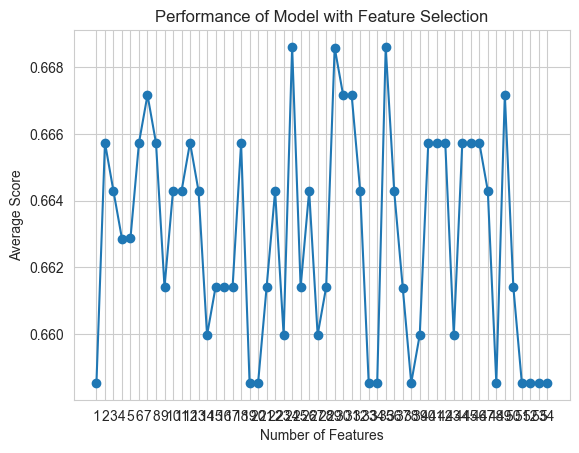

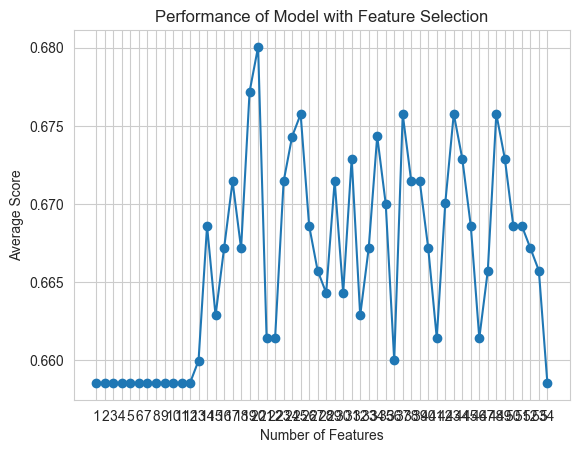

In [32]:
print("========================== Data 1  =================================")
print("SBFS")
slt_sbfs_features1_desb, score1_sbfs_desb = perform_feature_selection(X_train1, y_train1, modelo1_desb, "data1_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features1_desb, score1_sffs_desb = perform_feature_selection(X_train1, y_train1, modelo1_desb, "data1_desb", 'SFFS', 5)

========================== Data 2  =================================


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   14.5s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:   43.2s finished

[2023-12-24 13:04:19] Features: 83/1 -- score: 0.7862795477903392[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:   32.1s finished

[2023-12-24 13:04:51] Features: 82/1 -- score: 0.7905549845837616[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:   31.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.9s finished

[2023-12-24 13:05:26] Features: 81/1 -- score: 0.7877286742034944[Parallel(n_jobs=16)]: Usin

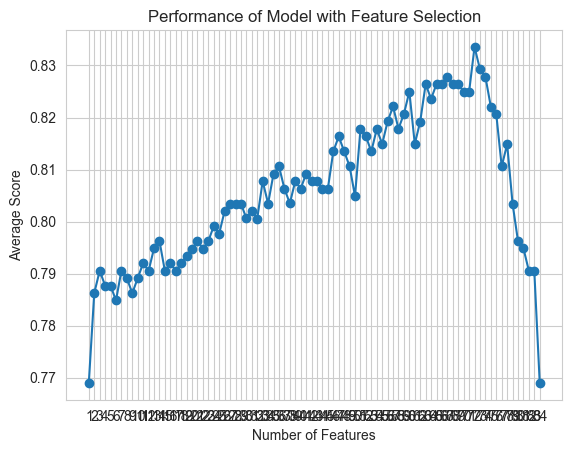

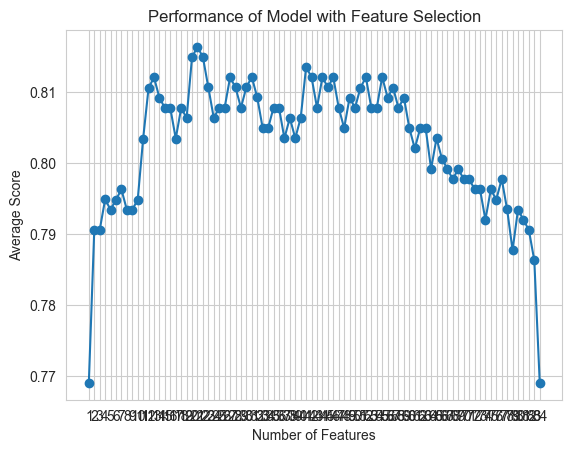

In [61]:
print("========================== Data 2  =================================")
slt_sbfs_features2_desb, score2_sbfs_desb = perform_feature_selection(X_train2, y_train2, modelo2_desb, "data2_desb", 'SBFS', 5)
slt_sffs_features2_desb, score2_sffs_desb = perform_feature_selection(X_train2, y_train2, modelo2_desb, "data2_desb", 'SFFS', 5)

========================== Data 3  =================================


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    0.4s finished

[2023-12-24 15:49:46] Features: 57/1 -- score: 0.7690750256937307[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    0.3s finished

[2023-12-24 15:49:46] Features: 56/1 -- score: 0.7719527235354573[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  56 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  56 out of  56 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[

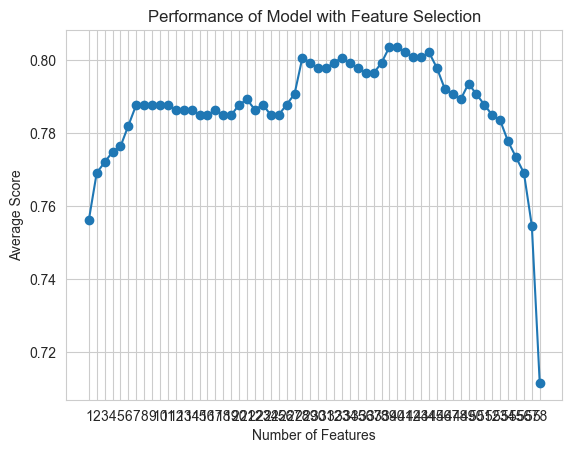

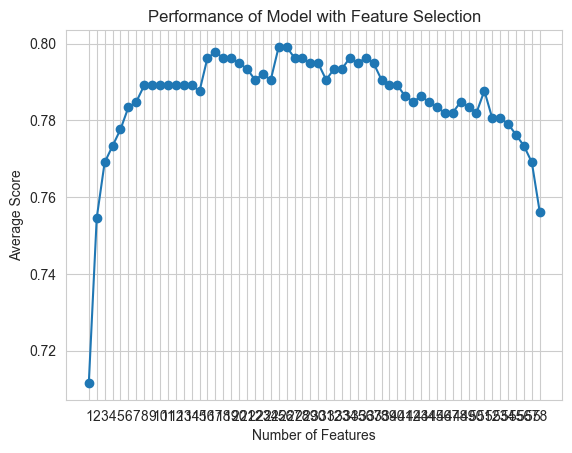

In [62]:
print("========================== Data 3  =================================")
print("SBFS")
slt_sbfs_features3_desb, score3_sbfs_desb = perform_feature_selection(X_train3, y_train3, modelo3_desb, "data3_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features3_desb, score3_sffs_desb = perform_feature_selection(X_train3, y_train3, modelo3_desb, "data3_desb", 'SFFS', 5)

========================== Data 4  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.9s finished

[2023-12-26 13:44:47] Features: 54/1 -- score: 0.6871942446043164[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.6s finished

[2023-12-26 13:44:48] Features: 53/1 -- score: 0.687235354573484[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.6s finis

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.2s finished

[2023-12-26 13:47:30] Features: 1/55 -- score: 0.658540596094553[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.2s finished

[2023-12-26 13:47:30] Features: 2/55 -- score: 0.658540596094553[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    1.0s finish

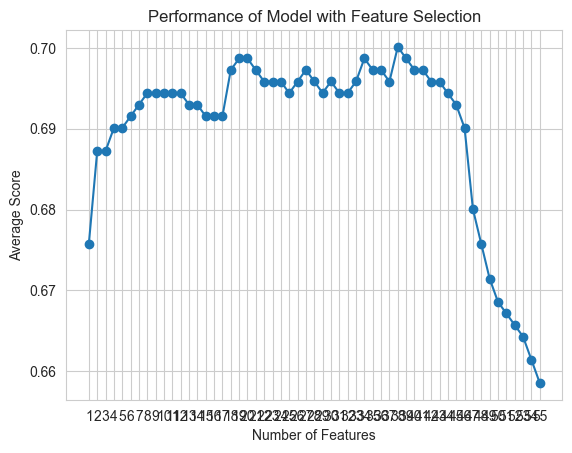

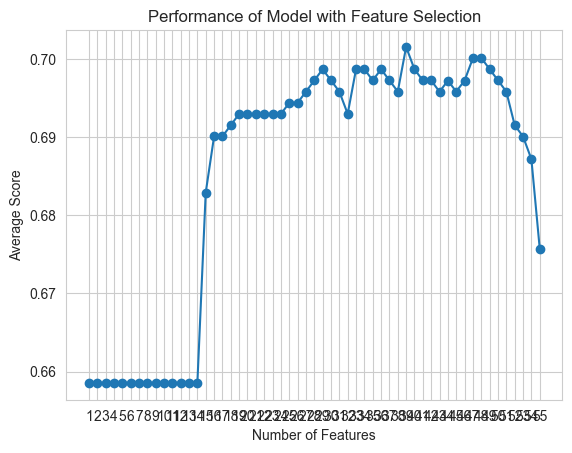

In [33]:
print("========================== Data 4  =================================")
print("SBFS")
slt_sbfs_features4_desb, score4_sbfs_desb = perform_feature_selection(X_train4, y_train4, modelo4_desb, "data4_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features4_desb, score4_sffs_desb = perform_feature_selection(X_train4, y_train4, modelo4_desb, "data4_desb", 'SFFS', 5)

========================== Data 5  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.9s finished

[2023-12-26 13:51:17] Features: 54/1 -- score: 0.6858067831449126[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.9s finished

[2023-12-26 13:51:18] Features: 53/1 -- score: 0.6901130524152107[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.9s fini

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.0s finished

[2023-12-26 13:53:33] Features: 1/55 -- score: 0.6656834532374101[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.0s finished

[2023-12-26 13:53:33] Features: 2/55 -- score: 0.6872353545734841[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.1s fini

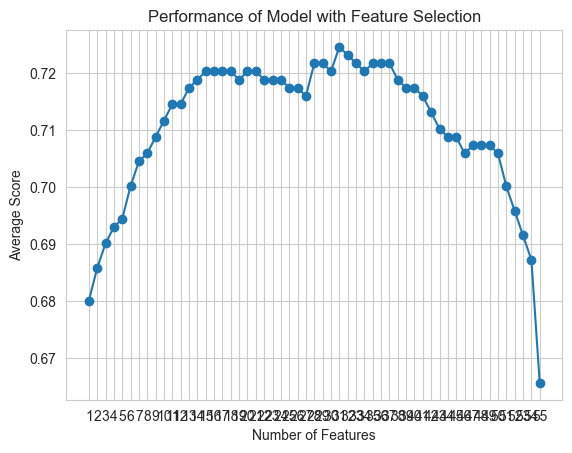

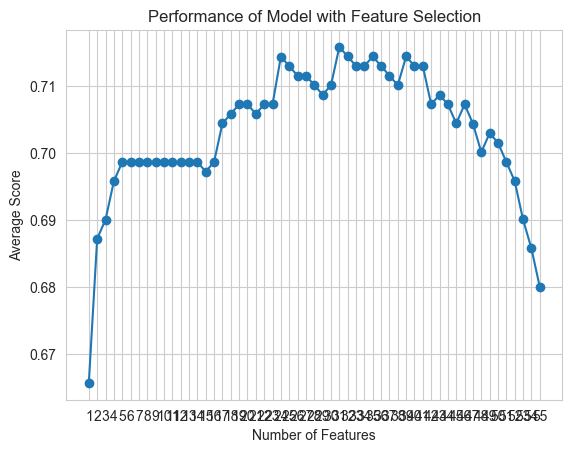

In [34]:
print("========================== Data 5  =================================")
print("SBFS")
slt_sbfs_features5_desb, score5_sbfs_desb = perform_feature_selection(X_train5, y_train5, modelo5_desb, "data5_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features5_desb, score5_sffs_desb = perform_feature_selection(X_train5, y_train5, modelo5_desb, "data5_desb", 'SFFS', 5)

========================== Data 6  =================================


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.3s finished

[2023-12-24 16:42:56] Features: 54/1 -- score: 0.7446043165467626[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.3s finished

[2023-12-24 16:42:56] Features: 53/1 -- score: 0.7517780061664954[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.3s fini

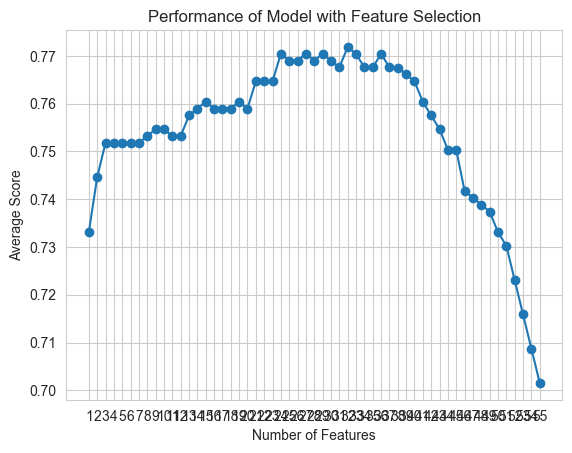

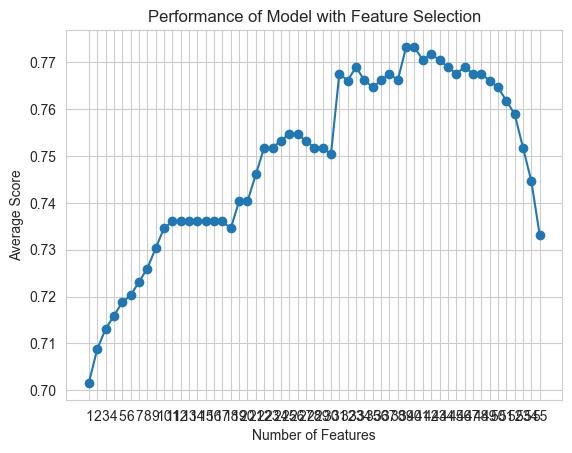

In [65]:
print("========================== Data 6  =================================")
print("SBFS")
slt_sbfs_features6_desb, score6_sbfs_desb = perform_feature_selection(X_train6, y_train6, modelo6_desb, "data6_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features6_desb, score6_sffs_desb = perform_feature_selection(X_train6, y_train6, modelo6_desb, "data6_desb", 'SFFS', 5)

#### Feature Selection nas bases com Random Under-Sampling

========================== Data 1  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   12.3s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:   39.3s remaining:    2.2s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:   39.4s finished

[2023-12-26 13:56:15] Features: 53/1 -- score: 0.6731494252873562[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   11.2s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:   37.6s remaining:    3.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:   37.7s finished

[2023-12-26 13:56:53] Features: 52/1 -- score: 0.6720065681444992[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   11.1s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:   34.0s remaining:    2.7s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:   36.9s fini

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:   23.1s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:   23.2s finished

[2023-12-26 14:49:53] Features: 1/54 -- score: 0.6594022988505748[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:   26.8s remaining:    2.1s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:   27.4s finished

[2023-12-26 14:50:21] Features: 2/54 -- score: 0.6651494252873563[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:   23.5s remaining:    1.9s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:   25.1s fini

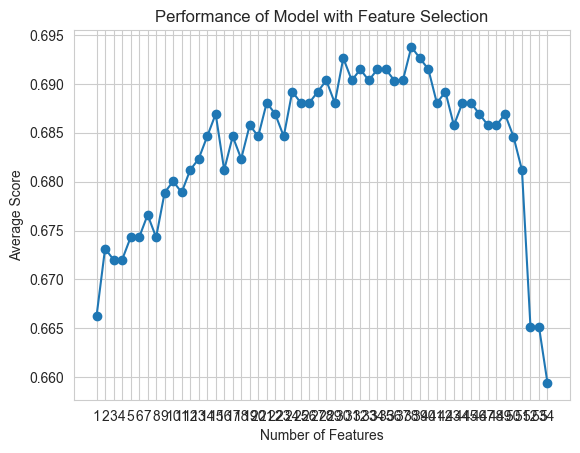

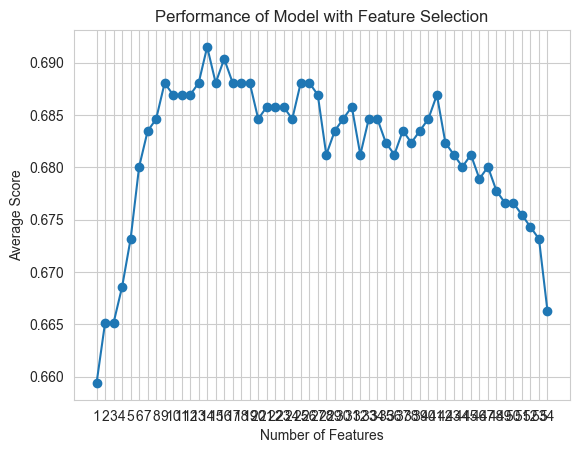

In [35]:
# Chamando a função de feature selection para cada um dos "modelos*"
print("========================== Data 1  =================================")
print("SBFS")
slt_sbfs_features1, score1_sbfs = perform_feature_selection(data1, target1, modelo1, "data1", 'SBFS', 5)
print("SFFS")
slt_sffs_features1, score1_sffs = perform_feature_selection(data1, target1, modelo1, "data1", 'SFFS', 5)

In [39]:
slt_sbfs_features1

('C',
 'M',
 'U',
 'AU',
 'AV',
 'AW',
 'AX',
 'AZ',
 'BD',
 'BP',
 'D_2.0',
 'E_1.0',
 'E_3.0',
 'E_4.0',
 'I_2.0',
 'AA_2.0',
 'AB_0.0')

========================== Data 2  =================================


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:    8.5s finished

[2023-12-24 15:53:56] Features: 83/1 -- score: 0.7741215106732348[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:    8.6s finished

[2023-12-24 15:54:05] Features: 82/1 -- score: 0.7729720853858785[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:    8.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.5s finished

[2023-12-24 15:54:15] Features: 81/1 -- score: 0.7729786535303778[Parallel(n_jobs=16)]: Usin

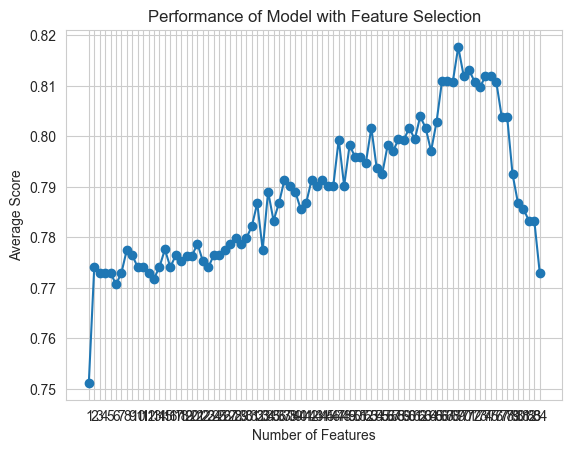

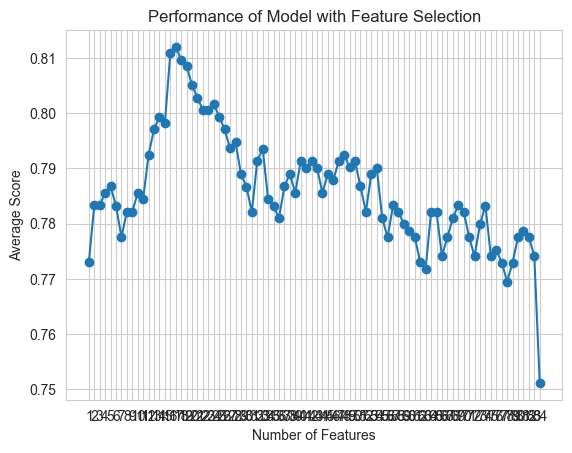

In [63]:
print("========================== Data 2  =================================")
print("SBFS")
slt_sbfs_features2, score2_sbfs = perform_feature_selection(data2, target2, modelo2, "data2", 'SBFS', 5)
print("SFFS")
slt_sffs_features2, score2_sffs = perform_feature_selection(data2, target2, modelo2,"data2", 'SFFS', 5)

========================== Data 3  =================================


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    0.7s finished

[2023-12-24 16:37:20] Features: 57/1 -- score: 0.7224761904761905[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    0.7s finished

[2023-12-24 16:37:21] Features: 56/1 -- score: 0.7293661740558293[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  54 out of  56 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  56 out of  56 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[

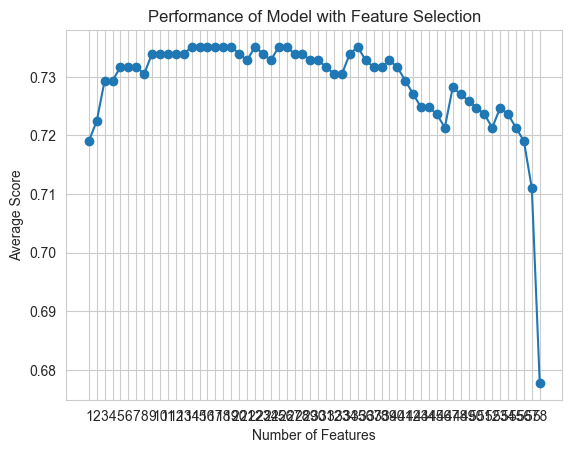

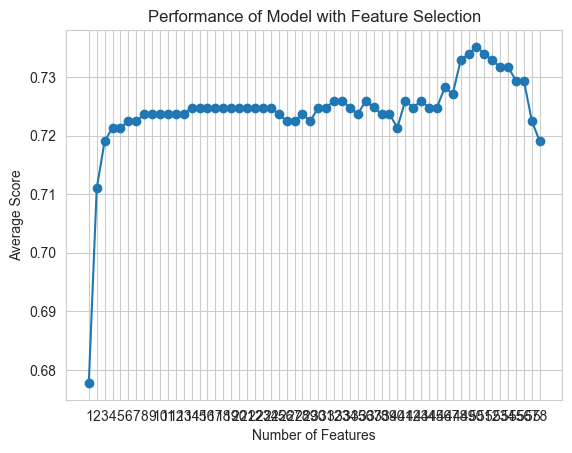

In [64]:
print("========================== Data 3  =================================")
print("SBFS")
slt_sbfs_features3, score3_sbfs = perform_feature_selection(data3, target3, modelo3, "data3", 'SBFS', 5)
print("SFFS")
slt_sffs_features3, score3_sffs = perform_feature_selection(data3, target3, modelo3, "data3", 'SFFS', 5)

========================== Data 4  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    6.6s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    6.7s finished

[2023-12-26 15:54:33] Features: 54/1 -- score: 0.6766042692939245[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    6.3s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    6.4s finished

[2023-12-26 15:54:39] Features: 53/1 -- score: 0.6788834154351395[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    6.1s remaining:    0.4s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    6.2s fini

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    4.8s finished

[2023-12-26 16:08:00] Features: 1/55 -- score: 0.6870016420361248[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    5.0s finished

[2023-12-26 16:08:05] Features: 2/55 -- score: 0.6915927750410509[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    4.8s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    4.9s fini

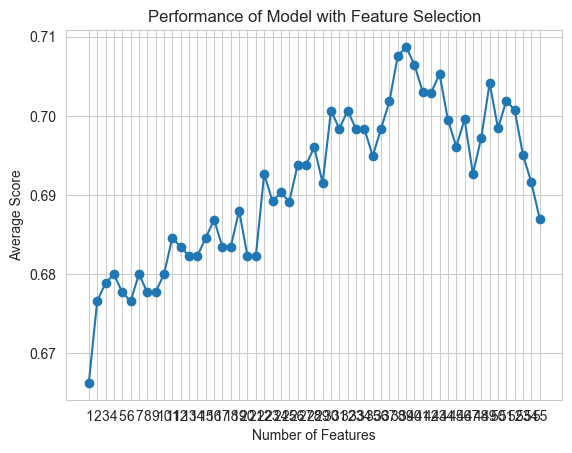

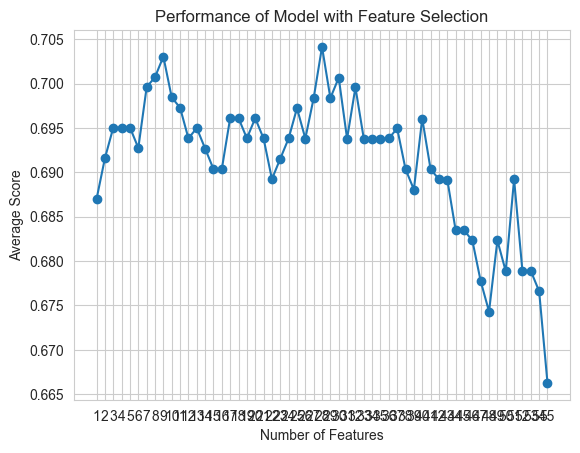

In [36]:
print("========================== Data 4  =================================")
print("SBFS")
slt_sbfs_features4, score4_sbfs = perform_feature_selection(data4, target4, modelo4,"data4", 'SBFS', 5)
print("SFFS")
slt_sffs_features4, score4_sffs = perform_feature_selection(data4, target4, modelo4, "data4", 'SFFS', 5)

In [37]:
print("========================== Data 5  =================================")
print("SBFS")
slt_sbfs_features5, score5_sbfs = perform_feature_selection(data5, target5, modelo5, "data5", 'SBFS', 5)
print("SFFS")
slt_sffs_features5, score5_sffs = perform_feature_selection(data5, target5, modelo5, "data5", 'SFFS', 5)

========================== Data 5  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    5.3s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    5.3s finished

[2023-12-26 16:19:53] Features: 54/1 -- score: 0.6628505747126436[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    5.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    5.3s finished

[2023-12-26 16:19:58] Features: 53/1 -- score: 0.6720065681444991[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    5.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    5.1s fini

TypeError: sequence item 3: expected str instance, int found

In [66]:
print("========================== Data 6  =================================")
print("SBFS")
slt_sbfs_features6, score6_sbfs = perform_feature_selection(data6, target6, modelo6, "data6", 'SBFS', 5)
print("SFFS")
slt_sffs_features6, score6_sffs = perform_feature_selection(data6, target6, modelo6, "data6", 'SFFS', 5)

========================== Data 6  =================================


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:   10.6s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:   10.6s finished

[2023-12-24 16:47:37] Features: 54/1 -- score: 0.745431855500821[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:   10.3s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:   10.3s finished

[2023-12-24 16:47:47] Features: 53/1 -- score: 0.7465812807881773[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    9.4s remaining:    0.7s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:   10.1s finis

TypeError: sequence item 6: expected str instance, int found

### Salvando as features selecionadas

#### Sem Random Under-Sampling

In [40]:
# Criando um arquivo txt com a feature selecionadas
with open(f"results/SBFS_data1_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features1_desb))
with open(f"results/SFFS_data1_desb.txt", "w") as f:
    f.write(str(slt_sffs_features1_desb))


# with open(f"results/SBFS_data2_desb.txt", "w") as f:
#     f.write(str(slt_sbfs_features2_desb))
# with open(f"results/SFFS_data2_desb.txt", "w") as f:
#     f.write(str(slt_sffs_features2_desb))
# with open(f"results/SBFS_data3_desb.txt", "w") as f:
#     f.write(str(slt_sbfs_features3_desb))
# with open(f"results/SFFS_data3_desb.txt", "w") as f:
#     f.write(str(slt_sffs_features3_desb))

with open(f"results/SBFS_data4_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features4_desb))
with open(f"results/SFFS_data4_desb.txt", "w") as f:
    f.write(str(slt_sffs_features4_desb))
with open(f"results/SBFS_data5_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features5_desb))
with open(f"results/SFFS_data5_desb.txt", "w") as f:
    f.write(str(slt_sffs_features5_desb))



# with open(f"results/SBFS_data6_desb.txt", "w") as f:
#     f.write(str(slt_sbfs_features6_desb))
# with open(f"results/SFFS_data6_desb.txt", "w") as f:
#     f.write(str(slt_sffs_features6_desb))

#### Com Random Under-Sampling

In [41]:
# Criando um arquivo txt com a feature selecionadas
with open(f"results/SBFS_data1.txt", "w") as f:
    f.write(str(slt_sbfs_features1))
with open(f"results/SFFS_data1.txt", "w") as f:
    f.write(str(slt_sffs_features1))

# with open(f"results/SBFS_data2.txt", "w") as f:
#     f.write(str(slt_sbfs_features2))
# with open(f"results/SFFS_data2.txt", "w") as f:
#     f.write(str(slt_sffs_features2))
# with open(f"results/SBFS_data3.txt", "w") as f:
#     f.write(str(slt_sbfs_features3))
# with open(f"results/SFFS_data3.txt", "w") as f:
#     f.write(str(slt_sffs_features3))
    
with open(f"results/SBFS_data4.txt", "w") as f:
    f.write(str(slt_sbfs_features4))
with open(f"results/SFFS_data4.txt", "w") as f:
    f.write(str(slt_sffs_features4))
with open(f"results/SBFS_data5.txt", "w") as f:
    f.write(str(slt_sbfs_features5))
with open(f"results/SFFS_data5.txt", "w") as f:
    f.write(str(slt_sffs_features5))
# 
# with open(f"results/SBFS_data6.txt", "w") as f:
#     f.write(str(slt_sbfs_features6))
# with open(f"results/SFFS_data6.txt", "w") as f:
#     f.write(str(slt_sffs_features6))

NameError: name 'slt_sbfs_features5' is not defined

### [Abrir features selecionadas]

In [ ]:
# Lendo os arquivos txt com as features selecionadas
slt_sbfs_features1 = ler_arquivo_txt('results/SBFS_data1.txt')[0]
slt_sffs_features1 = ler_arquivo_txt('results/SFFS_data1.txt')[0]
slt_sbfs_features2 = ler_arquivo_txt('results/SBFS_data2.txt')[0]
slt_sffs_features2 = ler_arquivo_txt('results/SFFS_data2.txt')[0]
slt_sbfs_features3 = ler_arquivo_txt('results/SBFS_data3.txt')[0]
slt_sffs_features3 = ler_arquivo_txt('results/SFFS_data3.txt')[0]
slt_sbfs_features4 = ler_arquivo_txt('results/SBFS_data4.txt')[0]
slt_sffs_features4 = ler_arquivo_txt('results/SFFS_data4.txt')[0]
slt_sbfs_features5 = ler_arquivo_txt('results/SBFS_data5.txt')[0]
slt_sffs_features5 = ler_arquivo_txt('results/SFFS_data5.txt')[0]
slt_sbfs_features6 = ler_arquivo_txt('results/SBFS_data6.txt')[0]
slt_sffs_features6 = ler_arquivo_txt('results/SFFS_data6.txt')[0]

### Avaliando os modelos com as features selecionadas

In [71]:
# Função para pegar as features selecionadas do csv. Essa função retorna uma lista com as features selecionadas.
def get_features_selected(file):
    df = pd.read_csv(file)
    # Seleciona a linha da coluna avg_score que possui o maior valor
    df = df.loc[df['avg_score'] == df['avg_score'].max()]
    
    # Agora pega as features na coluna feature_idx
    features = df['feature_idx'].values[0]
    
    # Transforma a string em lista
    features = features.replace(' ', '').replace('(', '').replace(')', '').split(',')
    
    # Transforma os elementos da lista em inteiros
    features = [int(i) for i in features]
    
    return features

In [86]:
get_features_selected(r'results/SBFS_data2_desb.csv')

[11, 38, 45, 46, 52, 55, 60, 62, 66, 72, 74, 79, 81]

#### Sem Random Under-Sampling

In [ ]:
# # Testando os modelos com as features selecionadas
# print("========================== Data 1  - SBFS =================================")
# perform_cross_validation(modelo1_desb, X_train1.loc[:,slt_sbfs_features1], x, 5, False)
# 
# print("========================== Data 1  - SFFS =================================")
# perform_cross_validation(modelo1, data1_re.loc[:,slt_sffs_features1], target1_re, 5, False)

In [90]:
print("========================== Data 2  - SBFS =================================")
slt_sbfs_features2_desb = get_features_selected(r'results/SBFS_data2_desb.csv')
perform_cross_validation(modelo2_desb, X_train2.iloc[:,slt_sbfs_features2_desb], y_train2, 5, False)

# Acuracaria com dados de teste
modelo2_desb.fit(X_train2.iloc[:,slt_sbfs_features2_desb], y_train2)
pred = modelo2_desb.predict(X_test2.iloc[:,slt_sbfs_features2_desb])
print(f'Acurácia: {accuracy_score(y_test2, pred)}')

print("========================== Data 2  - SFFS =================================")
slt_sffs_features2_desb = get_features_selected(r'results/SFFS_data2_desb.csv')
perform_cross_validation(modelo2_desb, X_train2.iloc[:,slt_sffs_features2_desb], y_train2, 5, False)

# Acuracaria com dados de teste
modelo2_desb.fit(X_train2.iloc[:,slt_sffs_features2_desb], y_train2)
pred = modelo2_desb.predict(X_test2.iloc[:,slt_sffs_features2_desb])
print(f'Acurácia: {accuracy_score(y_test2, pred)}')

========================== Data 2  - SBFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.57      0.69       119
           1       0.85      0.66      0.75       119
           2       0.83      0.95      0.88       459

    accuracy                           0.83       697
   macro avg       0.85      0.73      0.77       697
weighted avg       0.84      0.83      0.83       697

--------------------------------------------------
Accuracy: 0.83
Acurácia: 0.7371428571428571
========================== Data 2  - SFFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.50      0.63       119
           1       0.84      0.63      0.72       119
           2       0.81      0.95      0.87       459

    accuracy                           0.82       697
   macro avg       0.83      0.69     

In [91]:
print("========================== Data 3  - SBFS =================================")
slt_sbfs_features3_desb = get_features_selected(r'results/SBFS_data3_desb.csv')
perform_cross_validation(modelo3_desb, X_train3.iloc[:,slt_sbfs_features3_desb], y_train3, 5, False)

# Acuracaria com dados de teste
modelo3_desb.fit(X_train3.iloc[:,slt_sbfs_features3_desb], y_train3)
pred = modelo3_desb.predict(X_test3.iloc[:,slt_sbfs_features3_desb])
print(f'Acurácia: {accuracy_score(y_test3, pred)}')

print("========================== Data 3  - SFFS =================================")
slt_sffs_features3_desb = get_features_selected(r'results/SFFS_data3_desb.csv')
perform_cross_validation(modelo3_desb, X_train3.iloc[:,slt_sffs_features3_desb], y_train3, 5, False)

# Acuracaria com dados de teste
modelo3_desb.fit(X_train3.iloc[:,slt_sffs_features3_desb], y_train3)
pred = modelo3_desb.predict(X_test3.iloc[:,slt_sffs_features3_desb])
print(f'Acurácia: {accuracy_score(y_test3, pred)}')


========================== Data 3  - SBFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.51      0.63       119
           1       0.83      0.57      0.68       119
           2       0.80      0.94      0.86       459

    accuracy                           0.80       697
   macro avg       0.81      0.67      0.72       697
weighted avg       0.81      0.80      0.79       697

--------------------------------------------------
Accuracy: 0.80
Acurácia: 0.7485714285714286
========================== Data 3  - SFFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.43      0.57       119
           1       0.83      0.59      0.69       119
           2       0.79      0.95      0.86       459

    accuracy                           0.80       697
   macro avg       0.82      0.66     

In [ ]:
print("========================== Data 4  - SBFS =================================")
perform_cross_validation(modelo4, data4_re.loc[:,slt_sbfs_features4], target4_re, 5, False)

print("========================== Data 4  - SFFS =================================")
perform_cross_validation(modelo4, data4_re.loc[:,slt_sffs_features4], target4_re, 5, False)

In [ ]:
print("========================== Data 5  - SBFS =================================")
perform_cross_validation(modelo5, data5_re.loc[:,slt_sbfs_features5], target5_re, 5, False)

print("========================== Data 5  - SFFS =================================")
perform_cross_validation(modelo5, data5_re.loc[:,slt_sffs_features5], target5_re, 5, False)

In [ ]:
print("========================== Data 6  - SBFS =================================")
perform_cross_validation(modelo6, data6_re.loc[:,slt_sbfs_features6], target6_re, 5, False)

print("========================== Data 6  - SFFS =================================")
perform_cross_validation(modelo6, data6_re.loc[:,slt_sffs_features6], target6_re, 5, False)

#### Com Random Under-Sampling

## Matriz de Confusão

In [ ]:


# Definindo as classes
classes = ["Baixo", "Médio", "Alto"]

# Sua matriz de confusão de três classes
conf_matrix = np.array([[20, 0, 2],
                        [0, 30, 1],
                        [12, 3, 27]])

# Calculando precisão, recall e f1 score para cada classe
precision = []
recall = []
f1 = []

for i in range(len(conf_matrix)):
    TP = conf_matrix[i][i]
    FP = sum(conf_matrix[r][i] for r in range(len(conf_matrix)) if r != i)
    FN = sum(conf_matrix[i][c] for c in range(len(conf_matrix)) if c != i)

    precision.append(TP / (TP + FP))
    recall.append(TP / (TP + FN))
    f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))

# Criando um DataFrame com os resultados
df = pd.DataFrame({'Classe': classes, 'Precisão': precision, 'Recall': recall, 'F1 Score': f1})

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, annot_kws={"size": 14})
plt.xlabel('Classe Prevista', size=12, fontweight='bold')
plt.ylabel('Classe Real', size=12, fontweight='bold')
plt.title('Matriz de Confusão - SBFS - DATA 2', size=14, fontweight='bold')
plt.savefig('confusion_matrix_sbfs_data2.png', dpi=300, transparent=True)
plt.show()

# Exibindo a tabela com os resultados
print("Tabela de Resultados:")
df


